In [2]:
import gdown
from pathlib import Path
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import zscore, ks_2samp
from wordcloud import WordCloud
# %matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import zscore
import datetime as dt
import re
import pickle
import missingno as msno
from sklearn.preprocessing import LabelEncoder
import fancyimpute 
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')

# Raw data

In [112]:
# import raw data
def download_from_gdrive(url, filename):
    file_id = url.split('/')[-2]
    download_url = f"https://drive.google.com/uc?id={file_id}"
    if Path(filename).exists():
        print(f"File '{filename}' already exists. Skipping download.")
    else:
        gdown.download(download_url, filename, quiet=False)
        print(f"File downloaded as: {filename}")

US_Accidents_url = 'https://drive.google.com/file/d/11OZ7yANWhGUbCQHzG7Jea63ukozOOH8N/view?usp=sharing'

download_from_gdrive(US_Accidents_url, 'US_Accidents_March23_sampled_500k.csv')

df = pd.read_csv('US_Accidents_March23_sampled_500k.csv')

File 'US_Accidents_March23_sampled_500k.csv' already exists. Skipping download.


In [113]:
df1 = df.copy()
df1.shape

(500000, 46)

In [114]:
df1.describe()

Severity      Start_Lat      Start_Lng        End_Lat  \
count  500000.000000  500000.000000  500000.000000  279623.000000   
mean        2.212748      36.206421     -94.736583      36.273192   
std         0.486661       5.071411      17.405761       5.265333   
min         1.000000      24.562117    -124.497420      24.570110   
25%         2.000000      33.416823    -117.233047      33.474773   
50%         2.000000      35.832147     -87.794365      36.192669   
75%         2.000000      40.082443     -80.359601      40.181341   
max         4.000000      48.999569     -67.484130      48.998901   

             End_Lng   Distance(mi)  Temperature(F)  Wind_Chill(F)  \
count  279623.000000  500000.000000   489534.000000  370983.000000   
mean      -95.776553       0.564317       61.646254      58.229028   
std        18.120211       1.774872       19.000133      22.352246   
min      -124.497419       0.000000      -77.800000     -53.200000   
25%      -117.778324       0.000000       49.000000      43.000000   
50%       -88.039013       0.029000       64.000000      62.000000   
75%       -80.252449       0.465000       76.000000      75.000000   
max       -67.484130     193.479996      207.000000     207.000000   

         Humidity(%)   Pressure(in)  Visibility(mi)  Wind_Speed(mph)  \
count  488870.000000  491072.000000   488709.000000    463013.000000   
mean       64.834921      29.536621        9.091540         7.681347   
std        22.826158       1.008666        2.708083         5.431361   
min         1.000000       0.120000        0.000000         0.000000   
25%        48.000000      29.370000       10.000000         4.600000   
50%        67.000000      29.860000       10.000000         7.000000   
75%        84.000000      30.030000       10.000000        10.400000   
max       100.000000      38.440000      130.000000       822.800000   

       Precipitation(in)  
count      357384.000000  
mean            0.008289  
std             0.101865  
min             0.000000  
25%             0.000000  
50%             0.000000  
75%             0.000000  
max            10.130000

In [115]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     500000 non-null  object 
 1   Source                 500000 non-null  object 
 2   Severity               500000 non-null  int64  
 3   Start_Time             500000 non-null  object 
 4   End_Time               500000 non-null  object 
 5   Start_Lat              500000 non-null  float64
 6   Start_Lng              500000 non-null  float64
 7   End_Lat                279623 non-null  float64
 8   End_Lng                279623 non-null  float64
 9   Distance(mi)           500000 non-null  float64
 10  Description            499999 non-null  object 
 11  Street                 499309 non-null  object 
 12  City                   499981 non-null  object 
 13  County                 500000 non-null  object 
 14  State                  500000 non-nu

In [116]:
df1['ID'].nunique()

500000

# Convert type

In [117]:
df2 = df1.copy()

In [118]:
# Convert bool to Int

def change_bool_to_int(df, bool_lst):
    for col in bool_lst:
        df[col] = df[col].astype(int)

bool_lst = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout',
            'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

change_bool_to_int(df2, bool_lst)
df2[bool_lst].dtypes

Amenity            int64
Bump               int64
Crossing           int64
Give_Way           int64
Junction           int64
No_Exit            int64
Railway            int64
Roundabout         int64
Station            int64
Stop               int64
Traffic_Calming    int64
Traffic_Signal     int64
Turning_Loop       int64
dtype: object

In [119]:
# Convert Obj to Str

def change_object_to_string(df, obj_lst):
    for col in obj_lst:
        df[col] = df[col].astype('string')

obj_lst = ['ID', 'Source', 'Start_Time', 'End_Time', 'Description', 'Street', 'City', 'County', 'State',
           'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Wind_Direction',
            'Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

change_object_to_string(df2, obj_lst)
df2[obj_lst].dtypes

ID                       string[python]
Source                   string[python]
Start_Time               string[python]
End_Time                 string[python]
Description              string[python]
Street                   string[python]
City                     string[python]
County                   string[python]
State                    string[python]
Zipcode                  string[python]
Country                  string[python]
Timezone                 string[python]
Airport_Code             string[python]
Weather_Timestamp        string[python]
Wind_Direction           string[python]
Weather_Condition        string[python]
Sunrise_Sunset           string[python]
Civil_Twilight           string[python]
Nautical_Twilight        string[python]
Astronomical_Twilight    string[python]
dtype: object

In [120]:
# Clean punctuation in string columns

import string

def clean_string_punctuation(df, obj_lst):
    for col in obj_lst:
        df[col] = df[col].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)) if pd.notnull(x) else x)

            
filtered_lst = [elem for elem in obj_lst if elem != 'Start_Time' and elem != 'End_Time']                      
clean_string_punctuation(df2, filtered_lst)
change_object_to_string(df2, filtered_lst)
df2[filtered_lst].head()

ID   Source                                        Description  \
0  A2047758  Source2  Accident on LA19 BakerZachary Hwy at Lower Zac...   
1  A4694324  Source1  Incident on FOREST RIDGE DR near PEPPERIDGE PL...   
2  A5006183  Source1  Accident on W Central Ave from Floradale Ave t...   
3  A4237356  Source1  Incident on I90 EB near REST AREA Drive with c...   
4  A6690583  Source1  RP ADV THEY LOCATED SUSP VEH OF 20002  726 CRA...   

             Street         City            County State    Zipcode Country  \
0        Highway 19      Zachary  East Baton Rouge    LA  707914610      US   
1   Forest Ridge Dr     Sterling           Loudoun    VA  201642813      US   
2     Floradale Ave       Lompoc     Santa Barbara    CA      93436      US   
3        14th St NW       Austin             Mower    MN      55912      US   
4        River Blvd  Bakersfield              Kern    CA  933052649      US   

    Timezone Airport_Code Weather_Timestamp Wind_Direction Weather_Condition  \
0  USCentral         KBTR   20190612 095300             NW              Fair   
1  USEastern         KIAD   20221203 235200              W              Fair   
2  USPacific         KLPC   20220820 125600              W              Fair   
3  USCentral         KAUM   20220221 173500            ENE        Wintry Mix   
4  USPacific         KBFL   20201204 015400           CALM              Fair   

  Sunrise_Sunset Civil_Twilight Nautical_Twilight Astronomical_Twilight  
0            Day            Day               Day                   Day  
1          Night          Night             Night                 Night  
2            Day            Day               Day                   Day  
3            Day            Day               Day                   Day  
4          Night          Night             Night                 Night

# Manipulated data

In [121]:
df3 = df2.copy()
df3.shape

(500000, 46)

In [122]:
# Convert Start/End Time from String to Datetime

import re

def remove_digits_from_end(date_string):
    return re.sub(r'\.\d+$', '', date_string)

df3['Start_Time'] = df3['Start_Time'].apply(remove_digits_from_end)
df3['End_Time'] = df3['End_Time'].apply(remove_digits_from_end)

df3['Start_Time'] = pd.to_datetime(df3['Start_Time'], format="%Y-%m-%d %H:%M:%S")
df3['End_Time'] = pd.to_datetime(df3['End_Time'], format="%Y-%m-%d %H:%M:%S")

df3[['Start_Time', 'End_Time']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Start_Time  500000 non-null  datetime64[ns]
 1   End_Time    500000 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 7.6 MB


In [123]:
# Create Duration and convert timedelta64[ns] to timedelta64[m]

df3['Duration'] = df3['End_Time'] - df3['Start_Time']
df3['Duration'] = df3['Duration'] / np.timedelta64(1, 'h')
df3['Duration'].head()

0    0.750556
1    2.327500
2    2.162500
3    2.005278
4    2.452500
Name: Duration, dtype: float64

In [124]:
# Create Month, Day, Hour

df3['month'] = df3['Start_Time'].dt.month
df3['day'] = df3['Start_Time'].dt.day
df3['hour'] = df3['Start_Time'].dt.hour
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 50 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   ID                     500000 non-null  string        
 1   Source                 500000 non-null  string        
 2   Severity               500000 non-null  int64         
 3   Start_Time             500000 non-null  datetime64[ns]
 4   End_Time               500000 non-null  datetime64[ns]
 5   Start_Lat              500000 non-null  float64       
 6   Start_Lng              500000 non-null  float64       
 7   End_Lat                279623 non-null  float64       
 8   End_Lng                279623 non-null  float64       
 9   Distance(mi)           500000 non-null  float64       
 10  Description            499999 non-null  string        
 11  Street                 499309 non-null  string        
 12  City                   499981 non-null  stri

In [125]:
# focus on year 2019

df4 = df3[df3['Start_Time'].dt.year == 2019]
df4.shape

(61852, 50)

In [126]:
# remove Start_Time, End_Time

df5 = df4.drop(['Start_Time', 'End_Time'], axis=1)
df5.shape

(61852, 48)

In [127]:
df6 = df5.copy()

In [128]:
# dropping 16 columns

def drop_columns(df, drop_col_lst):
  for col in drop_col_lst:
    df.drop(col, axis=1, inplace=True)

drop_col_lst = ['Start_Lat'        #geographic           
                , 'Start_Lng'      #geographic 
                , 'End_Lat'        #geographic 
                , 'End_Lng'        #geographic 
                , 'Distance(mi)'   #78%=0.0
                , 'Country'        #all 'US'
                , 'Description'    #free text
                , 'Street'         #resolution
                , 'Zipcode'        #resolution
                , 'Timezone'       #no need
                , 'Airport_Code'   #no need
                , 'Weather_Timestamp' #no need
                , 'Wind_Direction' #drive direction unknown
                , 'Roundabout'     #all False
                , 'Turning_Loop'   #one single True
                , 'Civil_Twilight'    #no need
                , 'Nautical_Twilight' #no need
                , 'Astronomical_Twilight' #no need
               ]

drop_columns(df6, drop_col_lst)
df6.shape

(61852, 30)

# Pickle 1

In [135]:
# Write a pickle file

import pickle

In [136]:
# with open('df6.pkl', 'wb') as f:
#     pickle.dump(df6, f)

In [137]:
#Read a pickle file and load the data

with open('df6.pkl', 'rb') as file:
    loaded_df6 = pickle.load(file)

In [138]:
loaded_df6.shape

(61852, 30)

In [139]:
loaded_df6.head()

ID   Source  Severity         City            County State  \
0   A2047758  Source2         2      Zachary  East Baton Rouge    LA   
14  A2127689  Source2         2        Tempe          Maricopa    AZ   
30  A1722555  Source2         2       Denver            Denver    CO   
40  A2017804  Source2         2      Augusta          Richmond    GA   
51  A7296001  Source1         2  Minneapolis          Hennepin    MN   

    Temperature(F)  Wind_Chill(F)  Humidity(%)  Pressure(in)  ...  Railway  \
0             77.0           77.0         62.0         29.92  ...        0   
14            64.0           64.0         37.0         28.66  ...        0   
30            18.0           11.0         40.0         24.33  ...        0   
40            78.0           78.0         84.0         29.50  ...        0   
51            18.0            9.0         71.0         28.87  ...        0   

    Station  Stop Traffic_Calming  Traffic_Signal  Sunrise_Sunset  Duration  \
0         0     0               0               1             Day  0.750556   
14        0     0               0               1             Day  1.126389   
30        0     0               0               0           Night  0.520833   
40        0     0               0               1           Night  0.995833   
51        0     0               0               1           Night  0.884167   

    month  day  hour  
0       6   12    10  
14      5   28     7  
30     12   17     7  
40      8   12     5  
51     12   31    18  

[5 rows x 30 columns]

# Part 1

In [140]:
df7 = loaded_df6.copy()

In [104]:
# Data protocol

# import openpyxl

# large size files saved aside.

# df7.dtypes.to_excel("Accidents_datatype.xlsx",sheet_name='data_type')
# df7.max().to_excel("max_Accidents.xlsx", sheet_name='max')
# df7.min().to_excel("min_Accidents.xlsx", sheet_name='min')
# df7.isnull().sum(axis=0).to_excel("NA_Accidents.xlsx", sheet_name='NA')
# df7.nunique().to_excel("unique_Accidents.xlsx", sheet_name='unique')

In [105]:
# Automated reports - NOT SUPPORTED IN CURRENT PYTHON VERSION

# !pip install dataprep
# from dataprep.eda import create_report
# import pandas as pd

# report = create_report(df6)
# report.show_browser()

In [79]:
df7.shape

(61852, 30)

In [107]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61852 entries, 0 to 499994
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 61852 non-null  string 
 1   Source             61852 non-null  string 
 2   Severity           61852 non-null  int64  
 3   City               61851 non-null  string 
 4   County             61852 non-null  string 
 5   State              61852 non-null  string 
 6   Temperature(F)     60799 non-null  float64
 7   Wind_Chill(F)      52388 non-null  float64
 8   Humidity(%)        60742 non-null  float64
 9   Pressure(in)       61017 non-null  float64
 10  Visibility(mi)     60707 non-null  float64
 11  Wind_Speed(mph)    58082 non-null  float64
 12  Precipitation(in)  47611 non-null  float64
 13  Weather_Condition  60722 non-null  string 
 14  Amenity            61852 non-null  int64  
 15  Bump               61852 non-null  int64  
 16  Crossing           61852 n

In [108]:
df7.describe()

Severity  Temperature(F)  Wind_Chill(F)   Humidity(%)  \
count  61852.000000    60799.000000   52388.000000  60742.000000   
mean       2.310063       60.723489      60.094697     64.976392   
std        0.523333       19.485741      22.645303     22.709867   
min        1.000000      -27.900000     -53.200000      2.000000   
25%        2.000000       48.000000      45.000000     48.000000   
50%        2.000000       63.000000      64.000000     68.000000   
75%        3.000000       75.000000      77.000000     84.000000   
max        4.000000      115.000000     115.000000    100.000000   

       Pressure(in)  Visibility(mi)  Wind_Speed(mph)  Precipitation(in)  \
count  61017.000000    60707.000000     58082.000000       47611.000000   
mean      29.430581        9.080168         7.407772           0.006970   
std        1.100306        2.927134         5.250934           0.046538   
min       20.260000        0.000000         0.000000           0.000000   
25%       29.230000       10.000000         3.500000           0.000000   
50%       29.770000       10.000000         7.000000           0.000000   
75%       30.000000       10.000000        10.000000           0.000000   
max       31.120000      130.000000       142.000000           2.800000   

            Amenity          Bump  ...       No_Exit       Railway  \
count  61852.000000  61852.000000  ...  61852.000000  61852.000000   
mean       0.012805      0.000404  ...      0.003153      0.009878   
std        0.112432      0.020101  ...      0.056061      0.098899   
min        0.000000      0.000000  ...      0.000000      0.000000   
25%        0.000000      0.000000  ...      0.000000      0.000000   
50%        0.000000      0.000000  ...      0.000000      0.000000   
75%        0.000000      0.000000  ...      0.000000      0.000000   
max        1.000000      1.000000  ...      1.000000      1.000000   

            Station          Stop  Traffic_Calming  Traffic_Signal  \
count  61852.000000  61852.000000     61852.000000    61852.000000   
mean       0.023896      0.028892         0.000986        0.183794   
std        0.152726      0.167503         0.031389        0.387319   
min        0.000000      0.000000         0.000000        0.000000   
25%        0.000000      0.000000         0.000000        0.000000   
50%        0.000000      0.000000         0.000000        0.000000   
75%        0.000000      0.000000         0.000000        0.000000   
max        1.000000      1.000000         1.000000        1.000000   

           Duration         month           day          hour  
count  61852.000000  61852.000000  61852.000000  61852.000000  
mean       1.345292      6.819973     15.583845     11.857919  
std        9.670407      3.543803      8.711126      5.133539  
min        0.172222      1.000000      1.000000      0.000000  
25%        0.496667      4.000000      8.000000      8.000000  
50%        0.993333      7.000000     15.000000     11.000000  
75%        1.491111     10.000000     23.000000     16.000000  
max     1818.031389     12.000000     31.000000     23.000000  

[8 rows x 23 columns]

Shape of your Data Set loaded: (61852, 30)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
ID of type=string is not classified
Source of type=string is not classified
City of type=string is not classified
County of type=string is not classified
State of type=string is not classified
Weather_Condition of type=string is not classified
Sunrise_Sunset of type=string is not classified
    Number of Numeric Columns =  8
    Number of Integer-Categorical Columns =  4
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  11
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time

Number of All Scatter Plots = 36


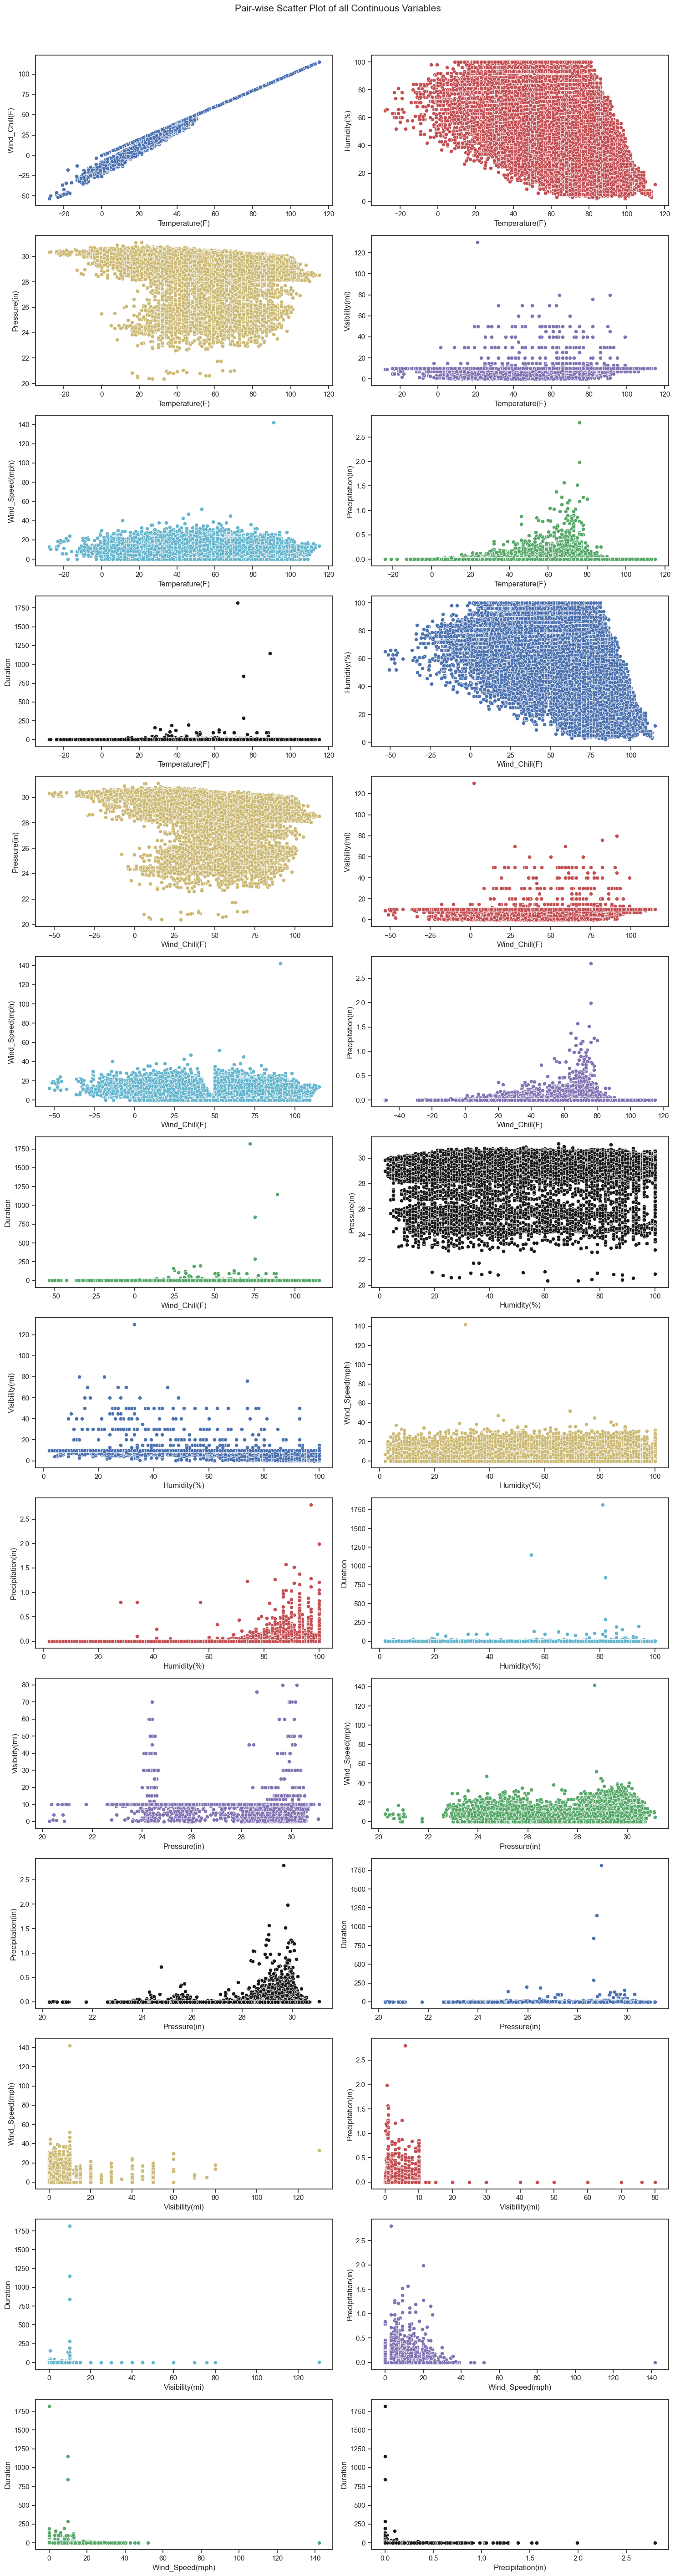

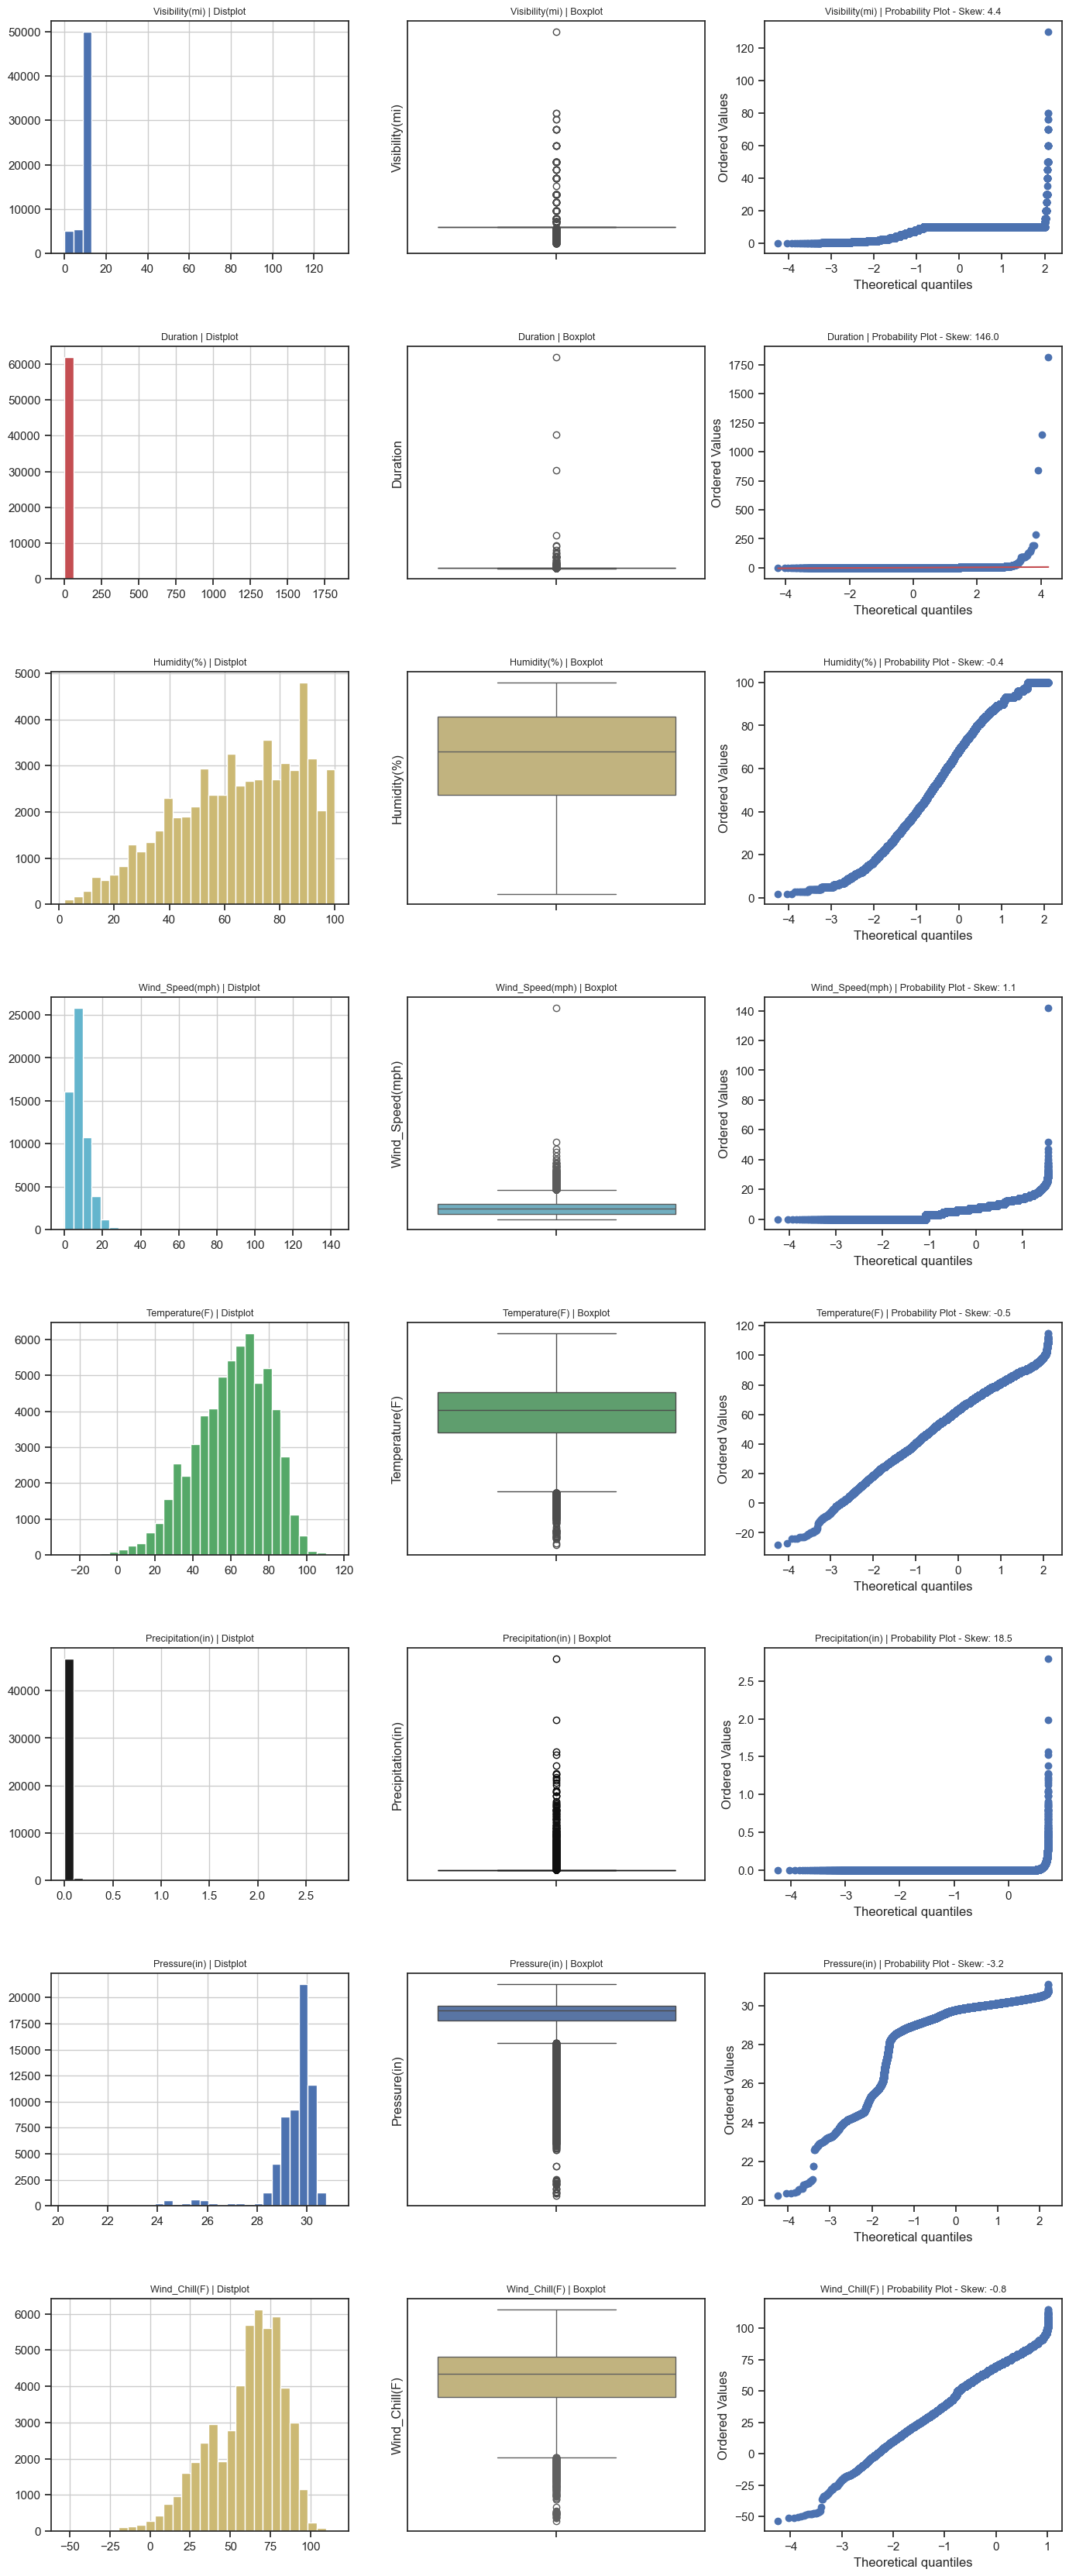

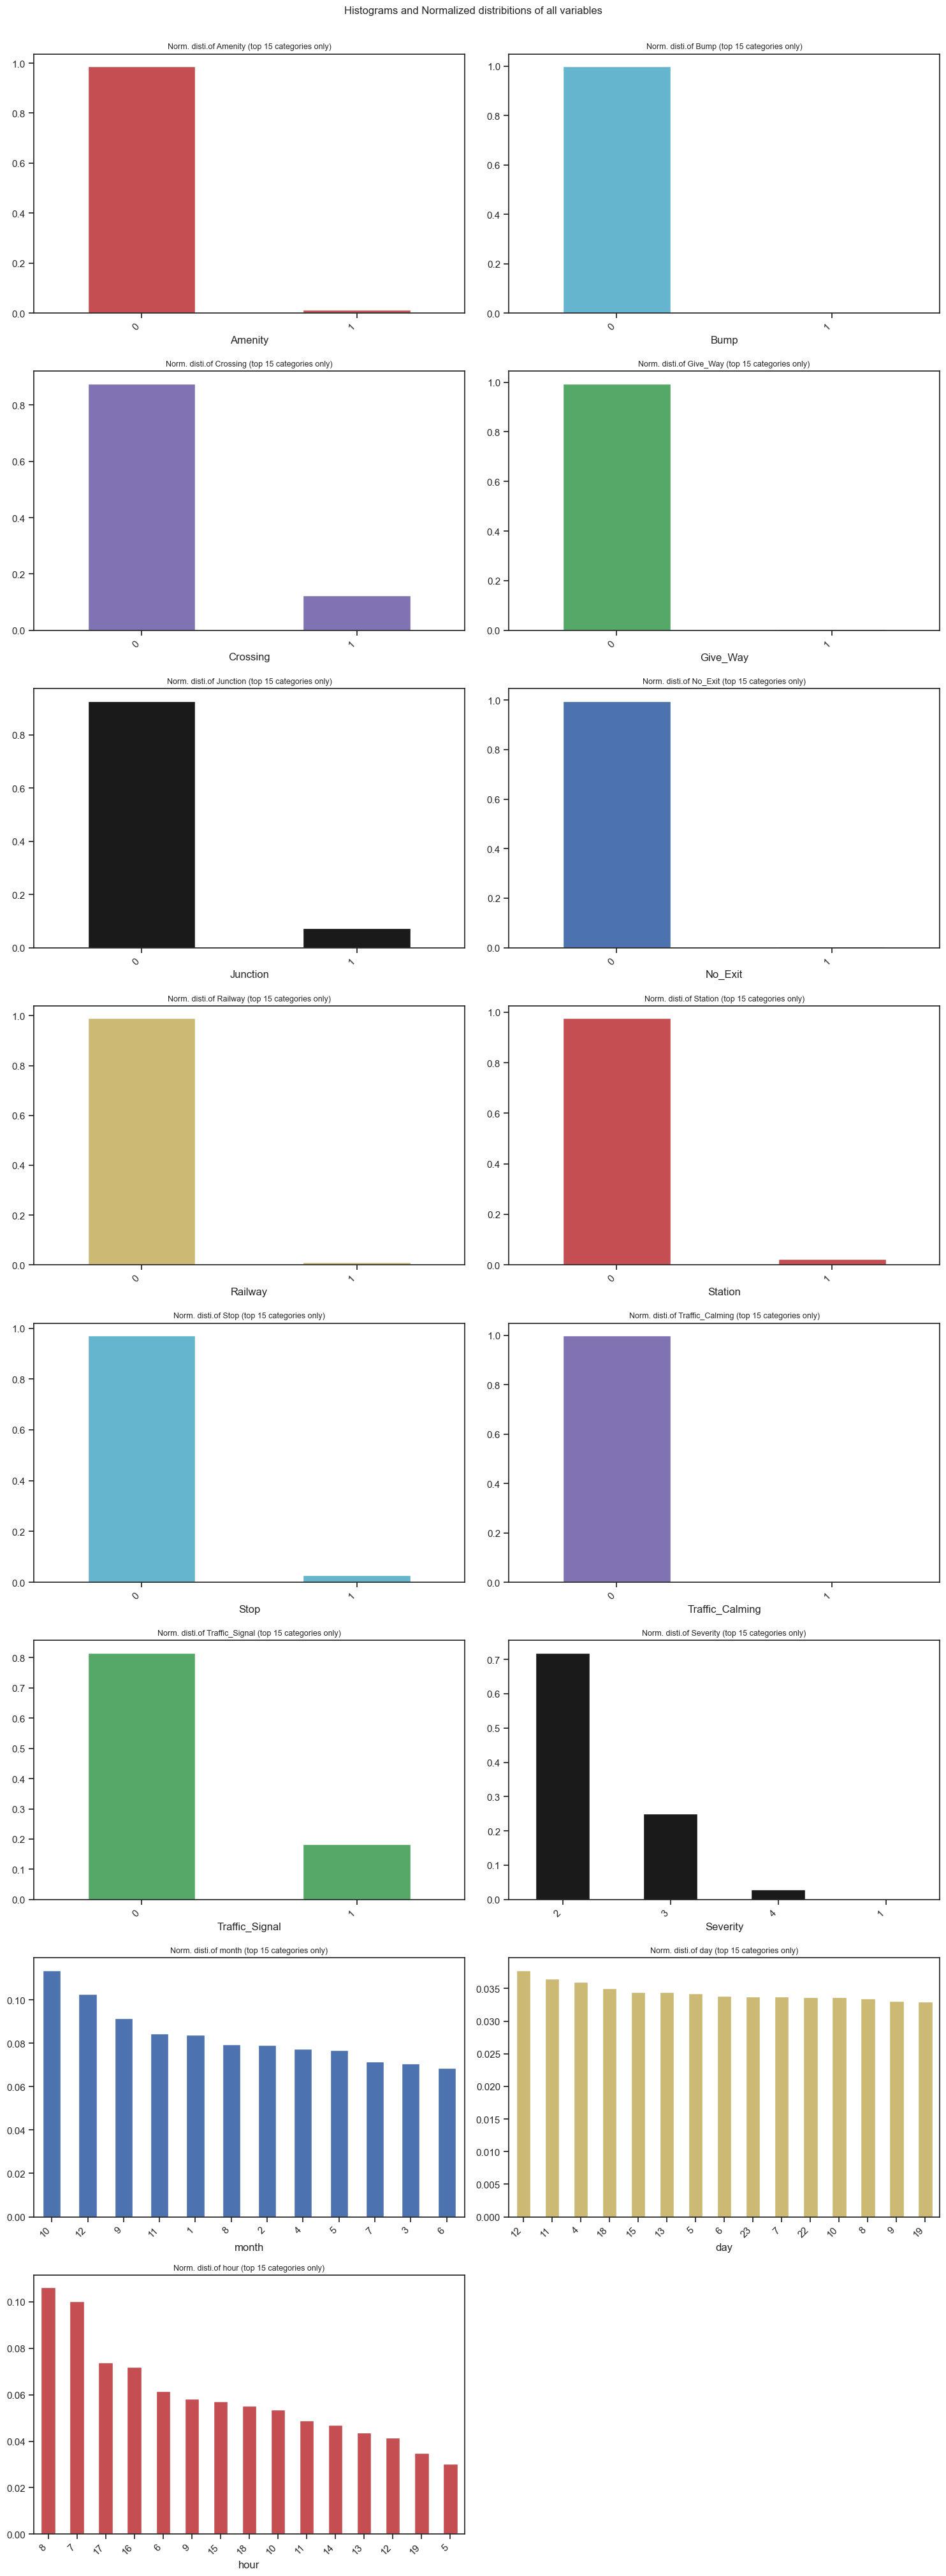

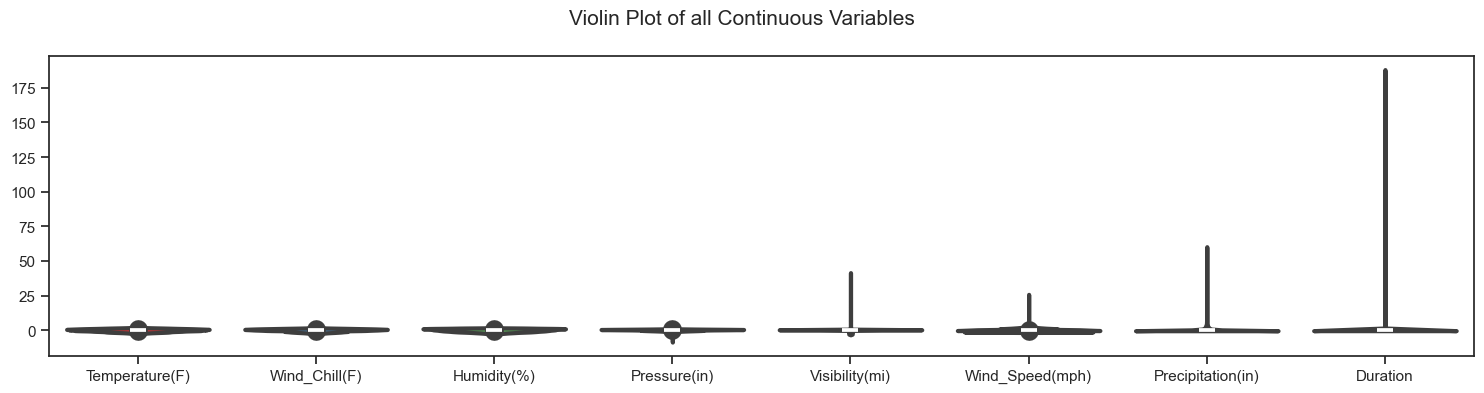

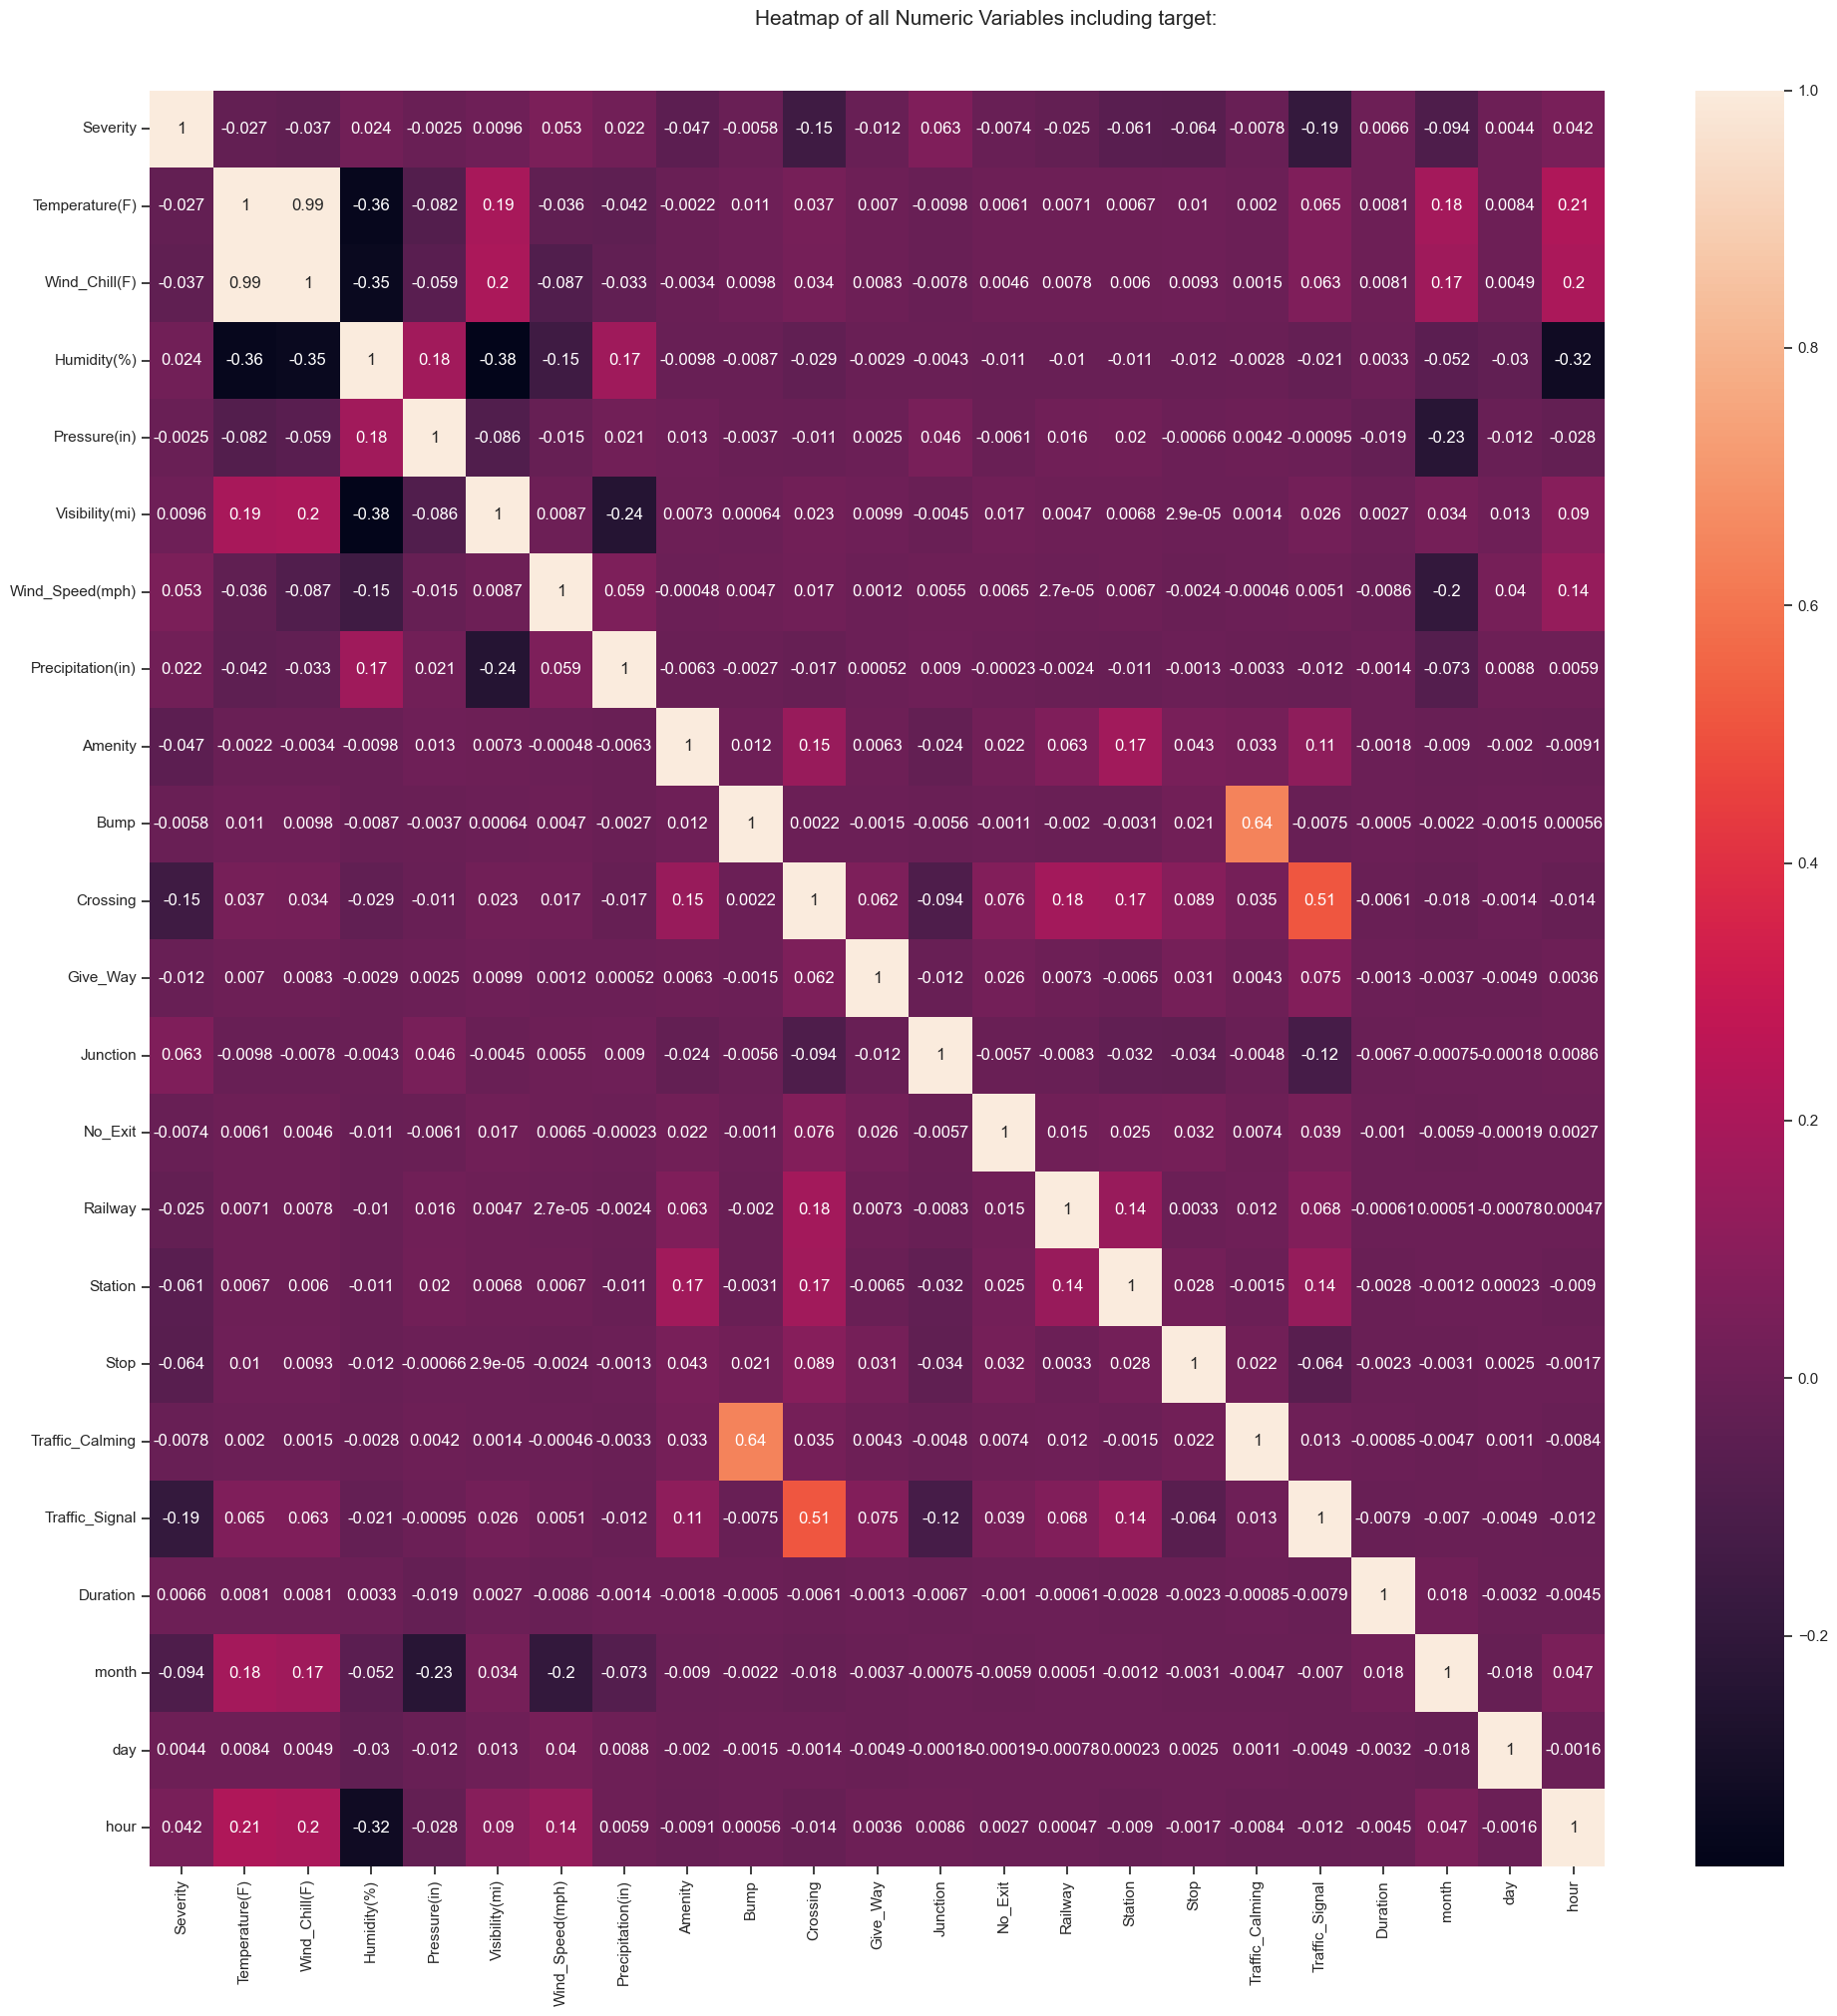

All Plots done
Time to run AutoViz = 25 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


ID     Source   Severity     City           County      State  \
0       A2047758  Source2      2         Zachary  East Baton Rouge   LA    
14      A2127689  Source2      2           Tempe          Maricopa   AZ    
30      A1722555  Source2      2          Denver            Denver   CO    
40      A2017804  Source2      2         Augusta          Richmond   GA    
51      A7296001  Source1      2     Minneapolis          Hennepin   MN    
...          ...      ...       ...          ...               ...   ...   
499948  A7364049  Source1      2          Madera            Madera   CA    
499971  A2142579  Source2      2       Charlotte       Mecklenburg   NC    
499975  A1679870  Source2      3     Los Angeles       Los Angeles   CA    
499980  A2239905  Source2      2       Grayslake              Lake   IL    
499994  A7376496  Source1      2          Rialto    San Bernardino   CA    

        Temperature(F)  Wind_Chill(F)  Humidity(%)  Pressure(in)  \
0            77.0           77.0          62.0          29.92      
14           64.0           64.0          37.0          28.66      
30           18.0           11.0          40.0          24.33      
40           78.0           78.0          84.0          29.50      
51           18.0            9.0          71.0          28.87      
...                ...            ...          ...           ...   
499948       52.0           52.0          35.0          30.00      
499971       41.0           36.0          55.0          29.42      
499975       53.0           53.0          57.0          29.62      
499980       36.0           30.3          73.0          30.51      
499994       90.0           90.0           7.0          28.72      

        Visibility(mi)  Wind_Speed(mph)  Precipitation(in) Weather_Condition  \
0            10.0             5.0               0.0                    Fair    
14           10.0             7.0               0.0                    Fair    
30           10.0             5.0               0.0           Partly Cloudy    
40           10.0             6.0               0.0                    Fair    
51           10.0             7.0               0.0                    Fair    
...                ...              ...                ...               ...   
499948        9.0             5.0               0.0                    Fair    
499971       10.0             7.0               0.0                  Cloudy    
499975       10.0             6.0               0.0                  Cloudy    
499980       10.0             6.9               NaN                   Clear    
499994       10.0             8.0               0.0                    Fair    

        Amenity  Bump  Crossing  Give_Way  Junction  No_Exit  Railway  \
0          0       0       0         0         0        0        0      
14         0       0       1         0         0        0        0      
30         0       0       0         0         0        0        0      
40         0       0       0         0         0        0        0      
51         0       0       1         0         0        0        0      
...         ...   ...       ...       ...       ...      ...      ...   
499948     0       0       0         0         0        0        0      
499971     0       0       0         0         0        0        0      
499975     0       0       0         0         0        0        0      
499980     0       0       0         0         0        0        0      
499994     0       0       0         0         0        0        0      

        Station  Stop  Traffic_Calming  Traffic_Signal Sunrise_Sunset  \
0          0       0          0                1              Day       
14         0       0          0                1              Day       
30         0       0          0                0            Night       
40         0       0          0                1            Night       
51         0       0          0                1            Night       
...  

In [92]:
from autoviz.AutoViz_Class import AutoViz_Class
%matplotlib inline

AV = AutoViz_Class()
# Use AutoViz with DataFrame
AV.AutoViz('', dfte=df6)

# Target value

Y - 
Shows the severity of the accident, a number between 1 and 4, where 1 indicates the least impact on traffic (i.e., short delay as a result of the accident) and 4 indicates a significant impact on traffic (i.e., long delay).

In [108]:
import matplotlib.pyplot as plt
import seaborn as sb

<Axes: xlabel='Severity', ylabel='count'>

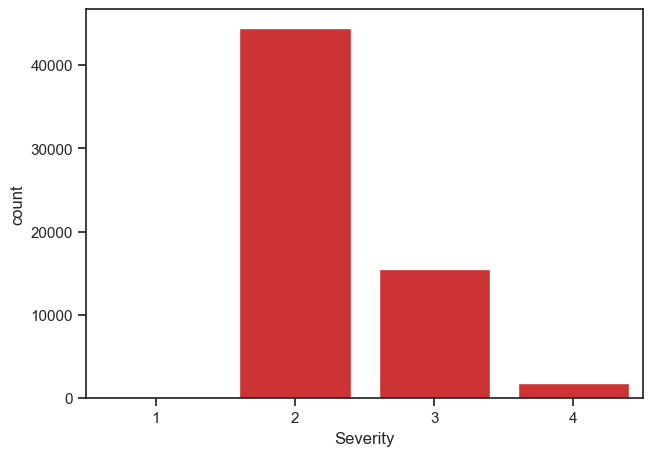

In [109]:
sb.countplot(x='Severity', data=df6)

In [110]:
df7['Severity'].value_counts()

Severity
2    44480
3    15518
4     1838
1       16
Name: count, dtype: int64

# ID

In [109]:
# unique ID is ok

df7['ID'].nunique()

61852

# Dummy data

In [8]:
cols_dummy = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
              'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']
dum_df = df7[cols_dummy]

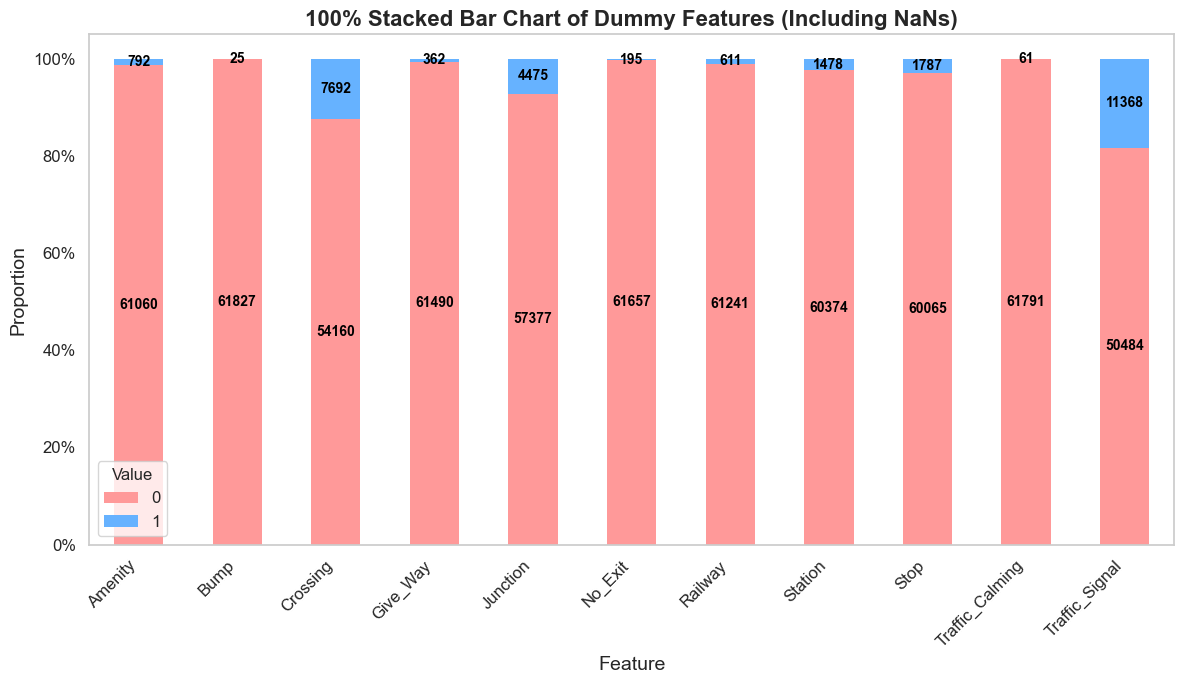

In [15]:
# Plotting dummy features

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid")
colors = ['#FF9999', '#66B2FF', '#CCCCCC']
counts = dum_df.apply(lambda x: x.value_counts(dropna=False)).T
proportions = dum_df.apply(lambda x: x.value_counts(dropna=False, normalize=True)).T
counts = counts.fillna(0)
proportions = proportions.fillna(0)
ax = proportions.plot(kind='bar', stacked=True, figsize=(12, 7), color=colors, edgecolor='none')
ax.set_title('100% Stacked Bar Chart of Dummy Features (Including NaNs)', fontsize=16, weight='bold')
ax.set_xlabel('Feature', fontsize=14)
ax.set_ylabel('Proportion', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(['{:.0f}%'.format(y*100) for y in ax.get_yticks()], fontsize=12)
ax.legend(title='Value', labels=['0', '1', 'NaN'], title_fontsize=12, fontsize=12)
for i in range(len(counts)):
    total = 0
    for j in range(len(counts.columns)):
        count = counts.iloc[i, j]
        proportion = proportions.iloc[i, j]
        if count > 0:
            ax.text(i, total + proportion/2, f'{int(count)}', ha='center', va='center', fontsize=10, color='black', weight='bold')
        total += proportion
ax.grid(False)
plt.tight_layout()
plt.show()

# Categorial data

In [90]:
cols_categorial = ['Source', 'Severity', 
                   'City', 'County', 'State', 
                   'Weather_Condition', 
                   'Sunrise_Sunset', 'month', 
                   'day', 'hour'
                  ]
cat_df = df7[cols_categorial]
cat_df.head()

Source  Severity         City            County State Weather_Condition  \
0   Source2         2      Zachary  East Baton Rouge    LA              Fair   
14  Source2         2        Tempe          Maricopa    AZ              Fair   
30  Source2         2       Denver            Denver    CO     Partly Cloudy   
40  Source2         2      Augusta          Richmond    GA              Fair   
51  Source1         2  Minneapolis          Hennepin    MN              Fair   

   Sunrise_Sunset  month  day  hour  
0             Day      6   12    10  
14            Day      5   28     7  
30          Night     12   17     7  
40          Night      8   12     5  
51          Night     12   31    18

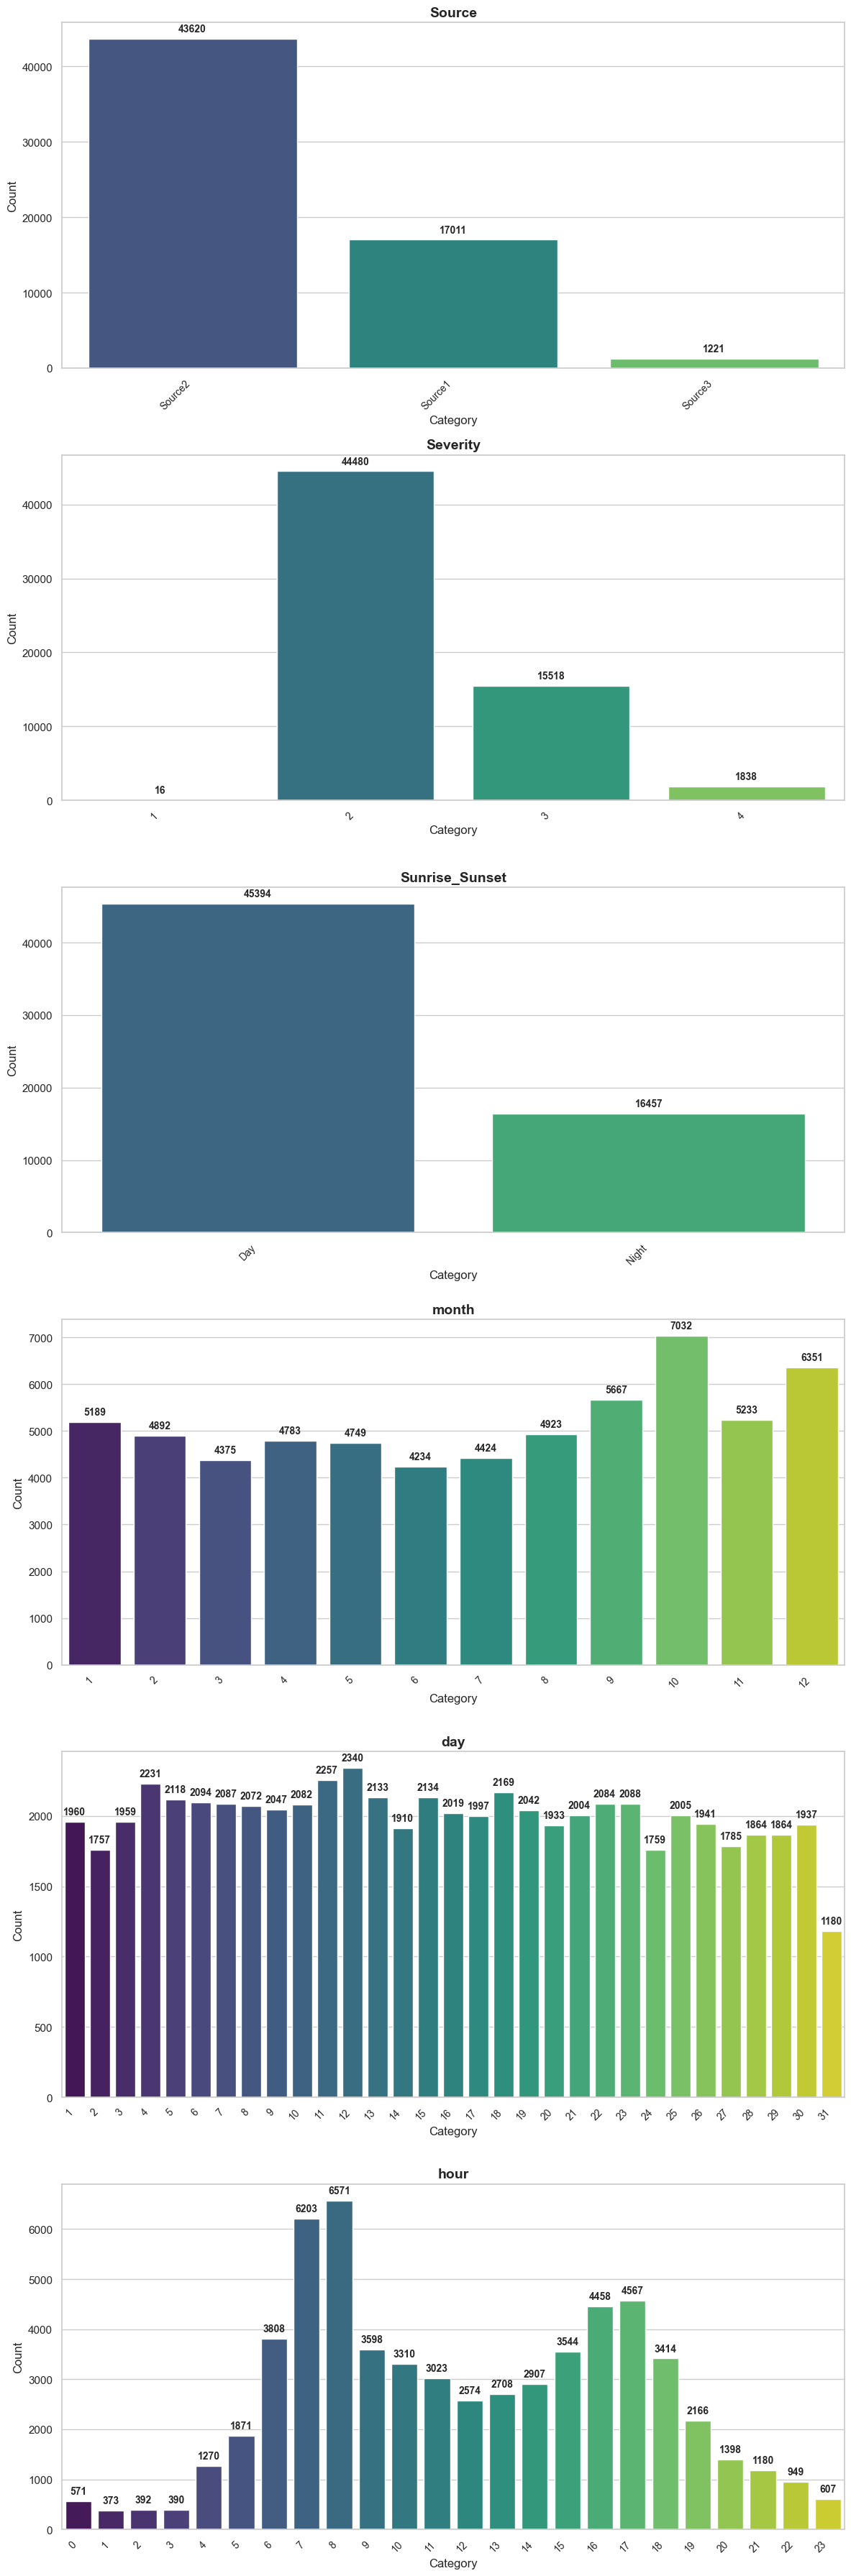

In [91]:
# Plotting some categorial data

def plot_categorical_features(df, columns):
    sb.set(style="whitegrid")
    n_rows = len(columns)
    fig, axes = plt.subplots(n_rows, 1, figsize=(12, n_rows * 6))
    if n_rows == 1:
        axes = [axes]
    for i, col in enumerate(columns):
        category_counts = df[col].value_counts()
        sb.barplot(x=category_counts.index, y=category_counts.values, ax=axes[i], palette="viridis")
        axes[i].set_title(f'{col}', fontsize=14, weight='bold')
        axes[i].set_xlabel('Category', fontsize=12)
        axes[i].set_ylabel('Count', fontsize=12)
        axes[i].tick_params(axis='x', rotation=45)
        for p in axes[i].patches:
            height = p.get_height()
            axes[i].annotate(f'{int(height)}', 
                             (p.get_x() + p.get_width() / 2., height), 
                             ha='center', va='bottom', 
                             xytext=(0, 5), 
                             textcoords='offset points', 
                             fontsize=10, weight='bold')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right', fontsize=10)
    plt.tight_layout()
    plt.show()
    
categorial_to_chart = ['Source', 'Severity', 
                   #'City', 'County', 'State', 
                   #'Weather_Condition', 
                   'Sunrise_Sunset', 'month', 
                   'day', 'hour'
                  ]    

plot_categorical_features(cat_df, categorial_to_chart)

#### categorial- City, County, State

In [82]:
# Unique values City

df7['City'].nunique()

4850

In [83]:
# Unique values County

df7['County'].nunique()

1031

In [85]:
# Unique values State

df7['State'].nunique()

49

#### categorial- Weather_Condition

In [89]:
df7['Weather_Condition'].nunique()

71

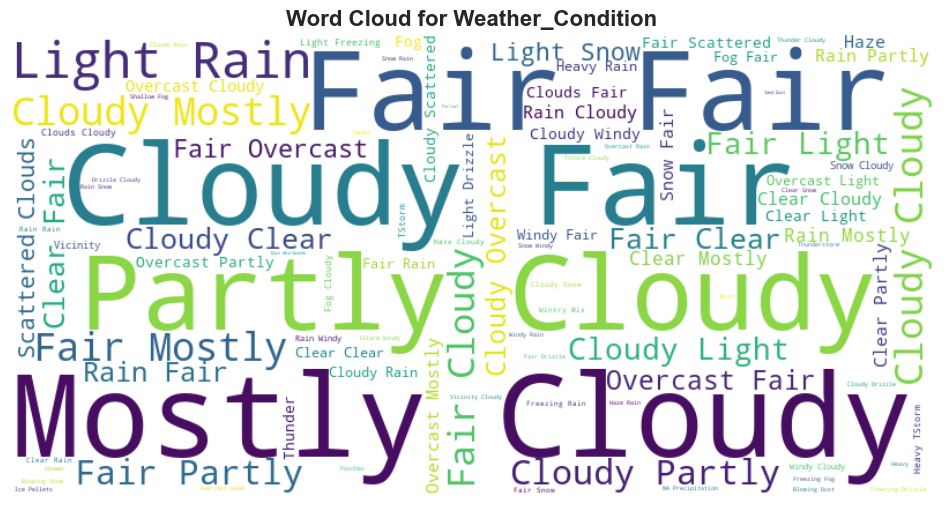

In [86]:
def plot_word_cloud(df, column):
    text = ' '.join(df[column].dropna().astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {column}', fontsize=16, weight='bold')
    plt.show()
plot_word_cloud(df7, 'Weather_Condition')

# Continues data

In [142]:
cols_continues = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
                  'Wind_Speed(mph)', 'Precipitation(in)', 'Duration'
                  ]
con_df = df7[cols_continues]
con_df.head()

Temperature(F)  Wind_Chill(F)  Humidity(%)  Pressure(in)  Visibility(mi)  \
0             77.0           77.0         62.0         29.92            10.0   
14            64.0           64.0         37.0         28.66            10.0   
30            18.0           11.0         40.0         24.33            10.0   
40            78.0           78.0         84.0         29.50            10.0   
51            18.0            9.0         71.0         28.87            10.0   

    Wind_Speed(mph)  Precipitation(in)  Duration  
0               5.0                0.0  0.750556  
14              7.0                0.0  1.126389  
30              5.0                0.0  0.520833  
40              6.0                0.0  0.995833  
51              7.0                0.0  0.884167

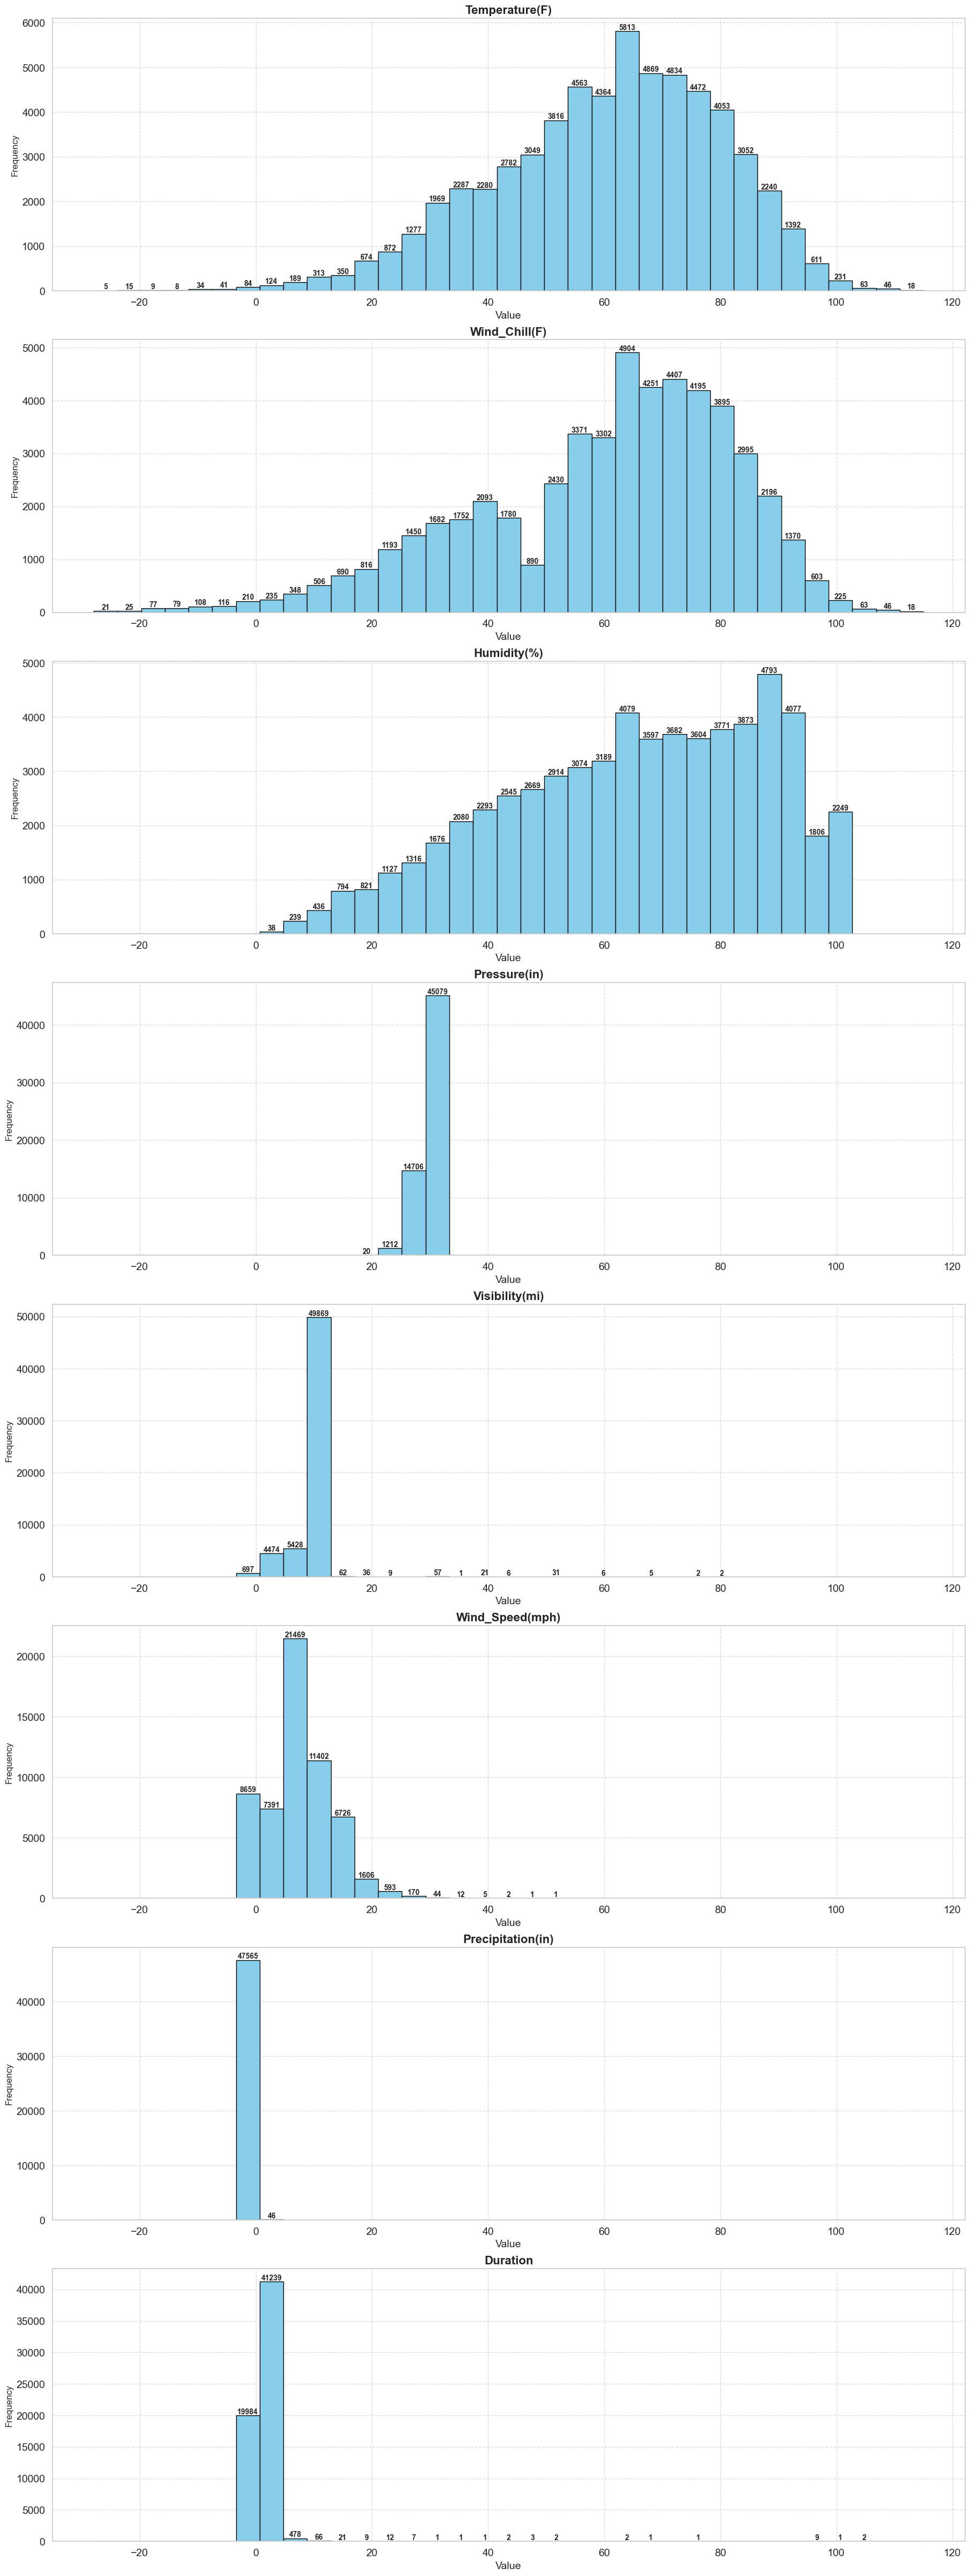

In [152]:
# Plotting continues data

def plot_histograms(df, columns, bins=35, figsize=(18, 48), xlabelsize=14, ylabelsize=12,
                    titlesize=16, color='skyblue', edgecolor='black'):
    n_cols = len(columns)
    fig, axes = plt.subplots(n_cols, 1, figsize=figsize, constrained_layout=True)
    if n_cols == 1:
        axes = [axes]
    for i, col in enumerate(columns):
        n, bins, patches = axes[i].hist(df[col].dropna(), bins=bins, color=color, edgecolor=edgecolor)
        axes[i].set_title(f'{col}', fontsize=titlesize, weight='bold')
        axes[i].set_xlabel('Value', fontsize=xlabelsize)
        axes[i].set_ylabel('Frequency', fontsize=ylabelsize)
        axes[i].tick_params(axis='both', which='major', labelsize=xlabelsize)
        axes[i].grid(True, linestyle='--', alpha=0.7)
        for patch in patches:
            height = patch.get_height()
            if height > 0:
                axes[i].annotate(f'{int(height)}', 
                                 (patch.get_x() + patch.get_width() / 2., height), 
                                 ha='center', va='bottom', 
                                 fontsize=10, weight='bold')
    plt.show()


plot_histograms(con_df, con_df.columns, bins=35, figsize=(18, 48), xlabelsize=14, 
                ylabelsize=12, titlesize=16, color='skyblue', edgecolor='black')

# Correlation
The Pearson correlation measures the linear relationship between two continuous variables

In [154]:
con_df.corr()

Temperature(F)  Wind_Chill(F)  Humidity(%)  Pressure(in)  \
Temperature(F)           1.000000       0.994657    -0.357284     -0.082495   
Wind_Chill(F)            0.994657       1.000000    -0.345105     -0.058889   
Humidity(%)             -0.357284      -0.345105     1.000000      0.175562   
Pressure(in)            -0.082495      -0.058889     0.175562      1.000000   
Visibility(mi)           0.192471       0.202928    -0.378997     -0.086130   
Wind_Speed(mph)         -0.035766      -0.087483    -0.151558     -0.014572   
Precipitation(in)       -0.042078      -0.032901     0.166786      0.021237   
Duration                 0.008072       0.008101     0.003289     -0.018685   

                   Visibility(mi)  Wind_Speed(mph)  Precipitation(in)  \
Temperature(F)           0.192471        -0.035766          -0.042078   
Wind_Chill(F)            0.202928        -0.087483          -0.032901   
Humidity(%)             -0.378997        -0.151558           0.166786   
Pressure(in)            -0.086130        -0.014572           0.021237   
Visibility(mi)           1.000000         0.008651          -0.241210   
Wind_Speed(mph)          0.008651         1.000000           0.058945   
Precipitation(in)       -0.241210         0.058945           1.000000   
Duration                 0.002678        -0.008570          -0.001350   

                   Duration  
Temperature(F)     0.008072  
Wind_Chill(F)      0.008101  
Humidity(%)        0.003289  
Pressure(in)      -0.018685  
Visibility(mi)     0.002678  
Wind_Speed(mph)   -0.008570  
Precipitation(in) -0.001350  
Duration           1.000000

<Axes: >

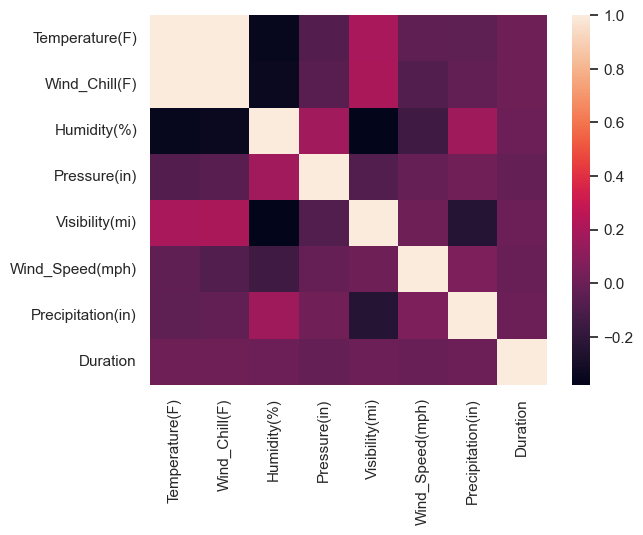

In [155]:
sb.heatmap(con_df.corr())

# Skewness
Skewness checks the symmetry of the probability distribution

In [156]:
def highlight(cell_value):
    highlight = 'background-color: mediumspringgreen;'
    default = ''
    negative = 'background-color: hotpink;'
    if cell_value > 1:
        return highlight
    elif cell_value < -1:
        return negative

pd.DataFrame(con_df.skew(),columns=['skewness']).sort_values(by='skewness', ascending=False).style.applymap(highlight)

# Part 2

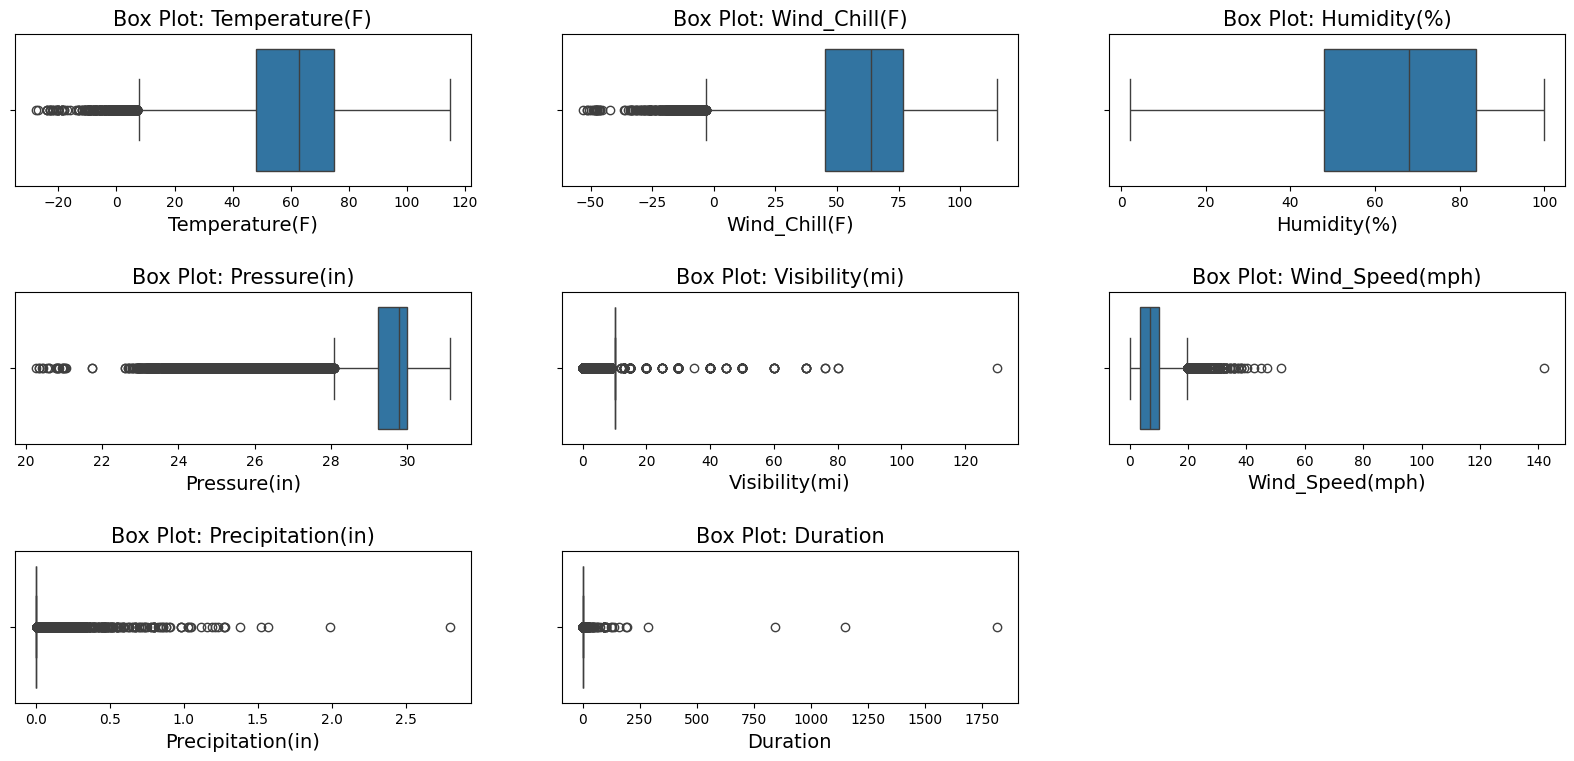

In [143]:
# Define the function to plot box plots for each numeric column

def outliers_boxplot(df):
    plt.figure(figsize=(20, 200))
    for i, col in enumerate(df.columns):
        ax = plt.subplot(60, 3, i + 1)
        sb.boxplot(data=df, x=col, ax=ax)
        plt.title(f'Box Plot: {col}', fontsize=15)
        plt.xlabel(f'{col}', fontsize=14)
    plt.subplots_adjust(hspace=0.7)
    plt.show()

# Assuming con_df contains the continuous numeric columns
outliers_boxplot(con_df)

# Outliers

In [152]:
df8 = df7.copy()

#### IQR

In [153]:
# Function to identify and treat outliers using IQR

def treat_outliers_iqr(df, features):
    df_outliers = pd.DataFrame(index=df.index)
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_outliers[feature] = ((df[feature] < lower_bound) | (df[feature] > upper_bound)).astype(int)
    return df_outliers

In [154]:
# Apply the outlier treatment function to numeric columns

numeric_cols = [
                #'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 
                'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Duration'
                ]
outliers_df = treat_outliers_iqr(df8, numeric_cols)
outliers_df

Pressure(in)  Visibility(mi)  Wind_Speed(mph)  Precipitation(in)  \
0                  0               0                0                  0   
14                 0               0                0                  0   
30                 1               0                0                  0   
40                 0               0                0                  0   
51                 0               0                0                  0   
...              ...             ...              ...                ...   
499948             0               1                0                  0   
499971             0               0                0                  0   
499975             0               0                0                  0   
499980             0               0                0                  0   
499994             0               0                0                  0   

        Duration  
0              0  
14             0  
30             0  
40             0  
51             0  
...          ...  
499948         0  
499971         0  
499975         1  
499980         0  
499994         0  

[61852 rows x 5 columns]

In [177]:
#Creating a table for outliers change

def create_outlier_table():
    outlier_table = pd.DataFrame(columns=['feature', 'outliers_cnt', 'distribution_changed', 'correlation_changed'])
    return outlier_table

out_df = create_outlier_table()
out_df

Empty DataFrame
Columns: [feature, outliers_cnt, distribution_changed, correlation_changed]
Index: []

In [156]:
# import pandas as pd
# import numpy as np
# from scipy.stats import ks_2samp

def check_changes(df, outliers_df, vars_to_check, target_var='Severity'):
    out_df = pd.DataFrame(columns=['feature', 'outliers_cnt', 'distribution_changed', 'correlation_changed'])
    for col in vars_to_check:
        out = df[col]
        non_out = df[col][outliers_df[col] == 0]
        cor_out = df[target_var]
        cor_non_out = df[target_var][outliers_df[col] == 0]

        # Filter out NaN values for correlation calculation
        valid_out = ~np.isnan(out) & ~np.isnan(cor_out)
        valid_non_out = ~np.isnan(non_out) & ~np.isnan(cor_non_out)

        if valid_out.sum() > 1 and valid_non_out.sum() > 1:
            cor_change = '+' if abs(np.corrcoef(out[valid_out], cor_out[valid_out])[0, 1] - 
                                    np.corrcoef(non_out[valid_non_out], cor_non_out[valid_non_out])[0, 1]) > 0.05 else '-'
        else:
            cor_change = '-'

        dist_change = '+' if ks_2samp(out.dropna(), non_out.dropna())[1] < 0.05 else '-'

        new_row = pd.DataFrame({'feature': [col],
                                'outliers_cnt': [outliers_df[col].sum()],
                                'distribution_changed': [dist_change],
                                'correlation_changed': [cor_change]})

        out_df = pd.concat([out_df, new_row], ignore_index=True)

    return out_df

In [157]:
out_df = check_changes(df8, outliers_df, numeric_cols)
out_df

feature outliers_cnt distribution_changed correlation_changed
0       Pressure(in)         3501                    +                   -
1     Visibility(mi)        12508                    +                   -
2    Wind_Speed(mph)         1447                    +                   -
3  Precipitation(in)         4397                    +                   -
4           Duration         4132                    +                   +

In [158]:
# Filter features where only distribution changes but not correlation

out_df['drop'] = np.where((out_df['distribution_changed'] == '+') & (out_df['correlation_changed'] == '-'), 'yes', 'no')
to_drop = out_df[out_df['drop'] == 'yes']['feature']

In [159]:
to_drop

0         Pressure(in)
1       Visibility(mi)
2      Wind_Speed(mph)
3    Precipitation(in)
Name: feature, dtype: object

In [160]:
# Remove outliers

df_cleaned = df8.copy()
for col in to_drop:
    df_cleaned.loc[outliers_df[col] == 1, col] = np.nan

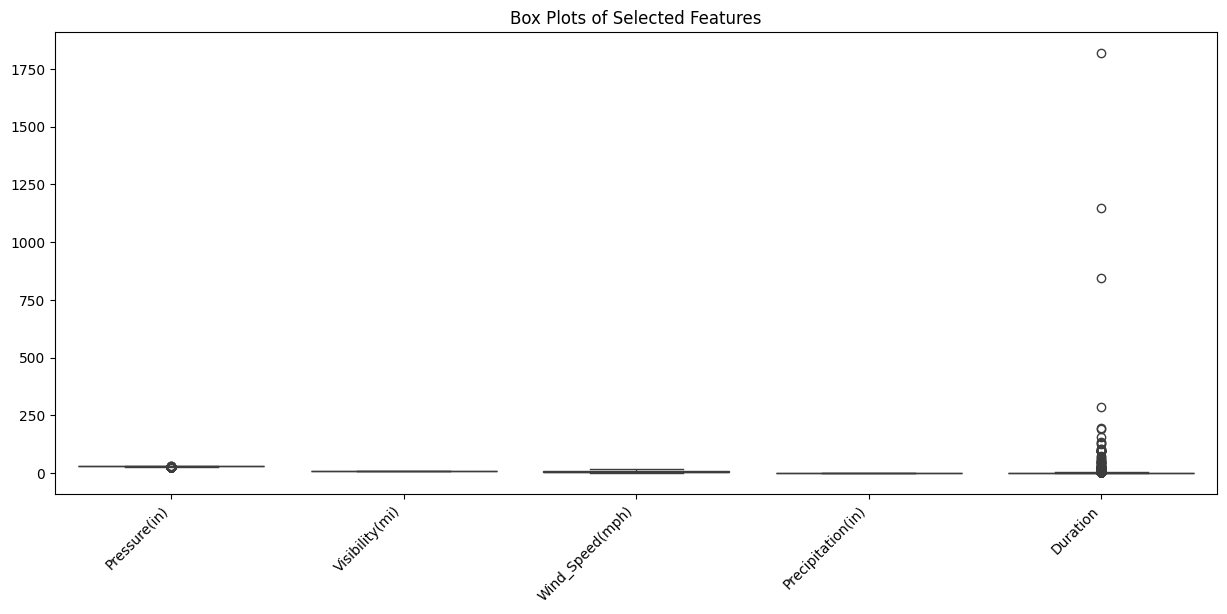

In [161]:
# plotting after IQR treat

columns_to_plot = ['Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Duration']

plt.figure(figsize=(15, 6))  # Adjust figure size as needed
sns.boxplot(data=df_cleaned[columns_to_plot])
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.title('Box Plots of Selected Features')
plt.show()

#### Z-score

In [239]:
df9 = df_cleaned.copy()

In [240]:
# Calculate Z-scores

def calculate_z_scores(df, columns):
    z_scores_df = pd.DataFrame()
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        col_data = df[col].dropna()
        z_scores = pd.Series(np.abs(stats.zscore(col_data)), index=col_data.index)
        z_scores_df[col] = z_scores
    return z_scores_df

cols_guassian = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)']
guassian_df = df9[cols_guassian]

z_scores_df = calculate_z_scores(guassian_df, cols_guassian)
print(z_scores_df)

        Temperature(F)  Wind_Chill(F)  Humidity(%)
0             0.842820       0.751104     0.131063
14            0.139665       0.132816     1.231915
30            2.348421       2.387896     1.099813
40            0.896909       0.798665     0.837687
51            2.348421       2.483017     0.265244
...                ...            ...          ...
499948        0.509401       0.437911     1.319983
499971        1.104378       1.198881     0.439301
499975        0.455312       0.390350     0.351233
499980        1.374822       1.469976     0.353312
499994        1.545975       1.369392     2.552937

[60028 rows x 3 columns]


In [180]:
# Function to identify and treat outliers using Z-score

def treat_outliers(df, features, threshold=2.5):
    outliers_df = pd.DataFrame(index=df.index)
    for feature in features:
        z = np.abs(zscore(df[feature], nan_policy='omit'))  # Handle NaNs
        outlier_mask = (z > threshold)
        outliers_df[feature] = outlier_mask.astype(float)  # Convert to float to allow NaNs
        outliers_df[feature] = outliers_df[feature].where(~df[feature].isna(), other=np.nan)  # Set NaN where original data is NaN

    return outliers_df

In [181]:
# Apply the outlier treatment function to numeric columns

numeric_cols = [
                'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)'
            #, 'Pressure(in)', 'Visibility(mi)'
            #, 'Wind_Speed(mph)', 'Precipitation(in)', 'Duration'
                  ]
outliers_df = treat_outliers(df9, numeric_cols)
outliers_df

Temperature(F)  Wind_Chill(F)  Humidity(%)
0                  0.0            0.0          0.0
14                 0.0            0.0          0.0
30                 0.0            0.0          0.0
40                 0.0            0.0          0.0
51                 0.0            0.0          0.0
...                ...            ...          ...
499948             0.0            0.0          0.0
499971             0.0            0.0          0.0
499975             0.0            0.0          0.0
499980             0.0            0.0          0.0
499994             0.0            0.0          1.0

[61852 rows x 3 columns]

In [182]:
out_df = create_outlier_table()
out_df

Empty DataFrame
Columns: [feature, outliers_cnt, distribution_changed, correlation_changed]
Index: []

In [183]:
out_df = check_changes(df9, outliers_df, numeric_cols)
out_df

feature  outliers_cnt distribution_changed correlation_changed
0  Temperature(F)         771.0                    +                   -
1   Wind_Chill(F)         840.0                    +                   -
2     Humidity(%)         277.0                    -                   -

In [184]:
# Filter features where only distribution changes but not correlation

out_df['drop'] = np.where((out_df['distribution_changed'] == '+') & (out_df['correlation_changed'] == '-'), 'yes', 'no')
to_drop = out_df[out_df['drop'] == 'yes']['feature']

In [185]:
to_drop

0    Temperature(F)
1     Wind_Chill(F)
Name: feature, dtype: object

In [186]:
# Remove outliers

df_cleaned = df9.copy()
for col in to_drop:
    df_cleaned.loc[outliers_df[col] == 1, col] = np.nan

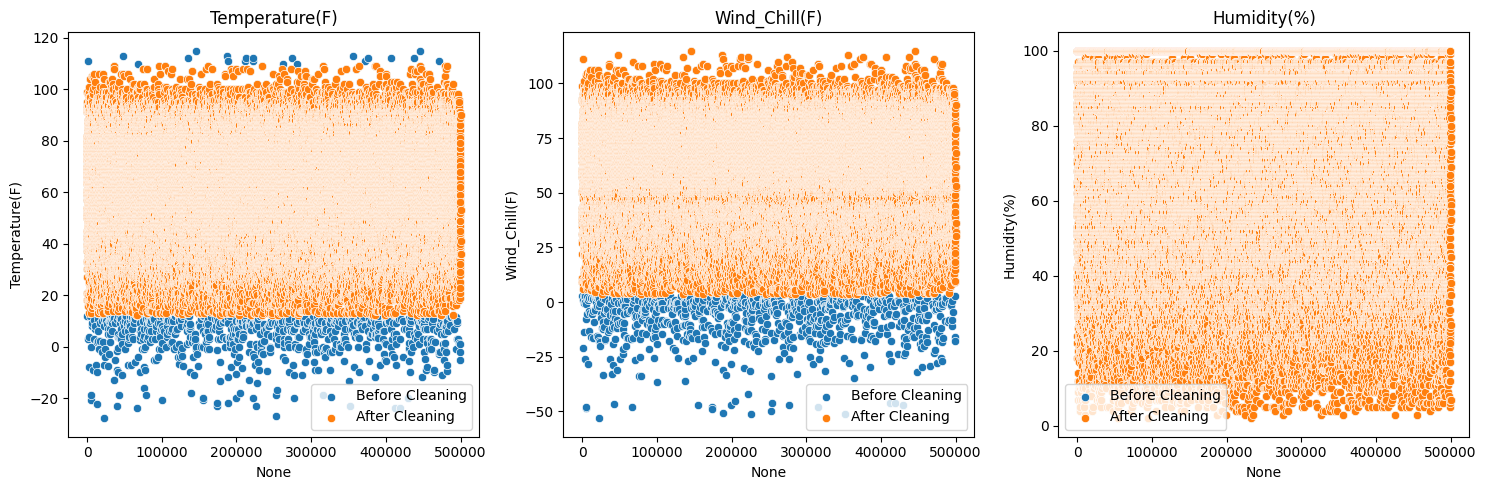

In [188]:
# Plotting after Z-score treat

columns_to_plot = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)']

fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(15, 5))

for i, col in enumerate(columns_to_plot):
    sb.scatterplot(x=df9.index, y=df9[col], ax=axes[i], label='Before Cleaning')
    sb.scatterplot(x=df_cleaned.index, y=df_cleaned[col], ax=axes[i], label='After Cleaning')
    axes[i].set_title(col)
    axes[i].legend()

plt.tight_layout()
plt.show()

# Pickle 2

In [191]:
# with open('df_cleaned.pkl', 'wb') as f:
#     pickle.dump(df_cleaned, f)

In [3]:
#Read a pickle file and load the data

with open('df_cleaned.pkl', 'rb') as file:
    df_cleaned = pickle.load(file)

In [4]:
df_cleaned.shape

(61852, 30)

In [5]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61852 entries, 0 to 499994
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 61852 non-null  string 
 1   Source             61852 non-null  string 
 2   Severity           61852 non-null  int64  
 3   City               61851 non-null  string 
 4   County             61852 non-null  string 
 5   State              61852 non-null  string 
 6   Temperature(F)     60028 non-null  float64
 7   Wind_Chill(F)      51548 non-null  float64
 8   Humidity(%)        60742 non-null  float64
 9   Pressure(in)       57516 non-null  float64
 10  Visibility(mi)     48199 non-null  float64
 11  Wind_Speed(mph)    56635 non-null  float64
 12  Precipitation(in)  43214 non-null  float64
 13  Weather_Condition  60722 non-null  string 
 14  Amenity            61852 non-null  int64  
 15  Bump               61852 non-null  int64  
 16  Crossing           61852 n

In [6]:
df_cleaned

ID   Source  Severity         City            County State  \
0       A2047758  Source2         2      Zachary  East Baton Rouge    LA   
14      A2127689  Source2         2        Tempe          Maricopa    AZ   
30      A1722555  Source2         2       Denver            Denver    CO   
40      A2017804  Source2         2      Augusta          Richmond    GA   
51      A7296001  Source1         2  Minneapolis          Hennepin    MN   
...          ...      ...       ...          ...               ...   ...   
499948  A7364049  Source1         2       Madera            Madera    CA   
499971  A2142579  Source2         2    Charlotte       Mecklenburg    NC   
499975  A1679870  Source2         3  Los Angeles       Los Angeles    CA   
499980  A2239905  Source2         2    Grayslake              Lake    IL   
499994  A7376496  Source1         2       Rialto    San Bernardino    CA   

        Temperature(F)  Wind_Chill(F)  Humidity(%)  Pressure(in)  ...  \
0                 77.0           77.0         62.0         29.92  ...   
14                64.0           64.0         37.0         28.66  ...   
30                18.0           11.0         40.0           NaN  ...   
40                78.0           78.0         84.0         29.50  ...   
51                18.0            9.0         71.0         28.87  ...   
...                ...            ...          ...           ...  ...   
499948            52.0           52.0         35.0         30.00  ...   
499971            41.0           36.0         55.0         29.42  ...   
499975            53.0           53.0         57.0         29.62  ...   
499980            36.0           30.3         73.0         30.51  ...   
499994            90.0           90.0          7.0         28.72  ...   

        Railway  Station  Stop Traffic_Calming  Traffic_Signal  \
0             0        0     0               0               1   
14            0        0     0               0               1   
30            0        0     0               0               0   
40            0        0     0               0               1   
51            0        0     0               0               1   
...         ...      ...   ...             ...             ...   
499948        0        0     0               0               0   
499971        0        0     0               0               0   
499975        0        0     0               0               0   
499980        0        0     0               0               0   
499994        0        0     0               0               0   

        Sunrise_Sunset  Duration  month  day  hour  
0                  Day  0.750556      6   12    10  
14                 Day  1.126389      5   28     7  
30               Night  0.520833     12   17     7  
40               Night  0.995833      8   12     5  
51               Night  0.884167     12   31    18  
...                ...       ...    ...  ...   ...  
499948             Day  0.911944     10   31    10  
499971             Day  1.771111      4    2     8  
499975             Day  4.796389     12   26    10  
499980             Day  0.494722      3   26     8  
499994             Day  1.545556     11    9    16  

[61852 rows x 30 columns]

# Missing values

If 'feature' is less than 60% missing
we could consider using the null as an additional category:
df['feature'] = df['feature'].fillna('H')<br>
If almost 80% missing, we will remove it: del df['feature']

In [7]:
df10 = df_cleaned

<Axes: >

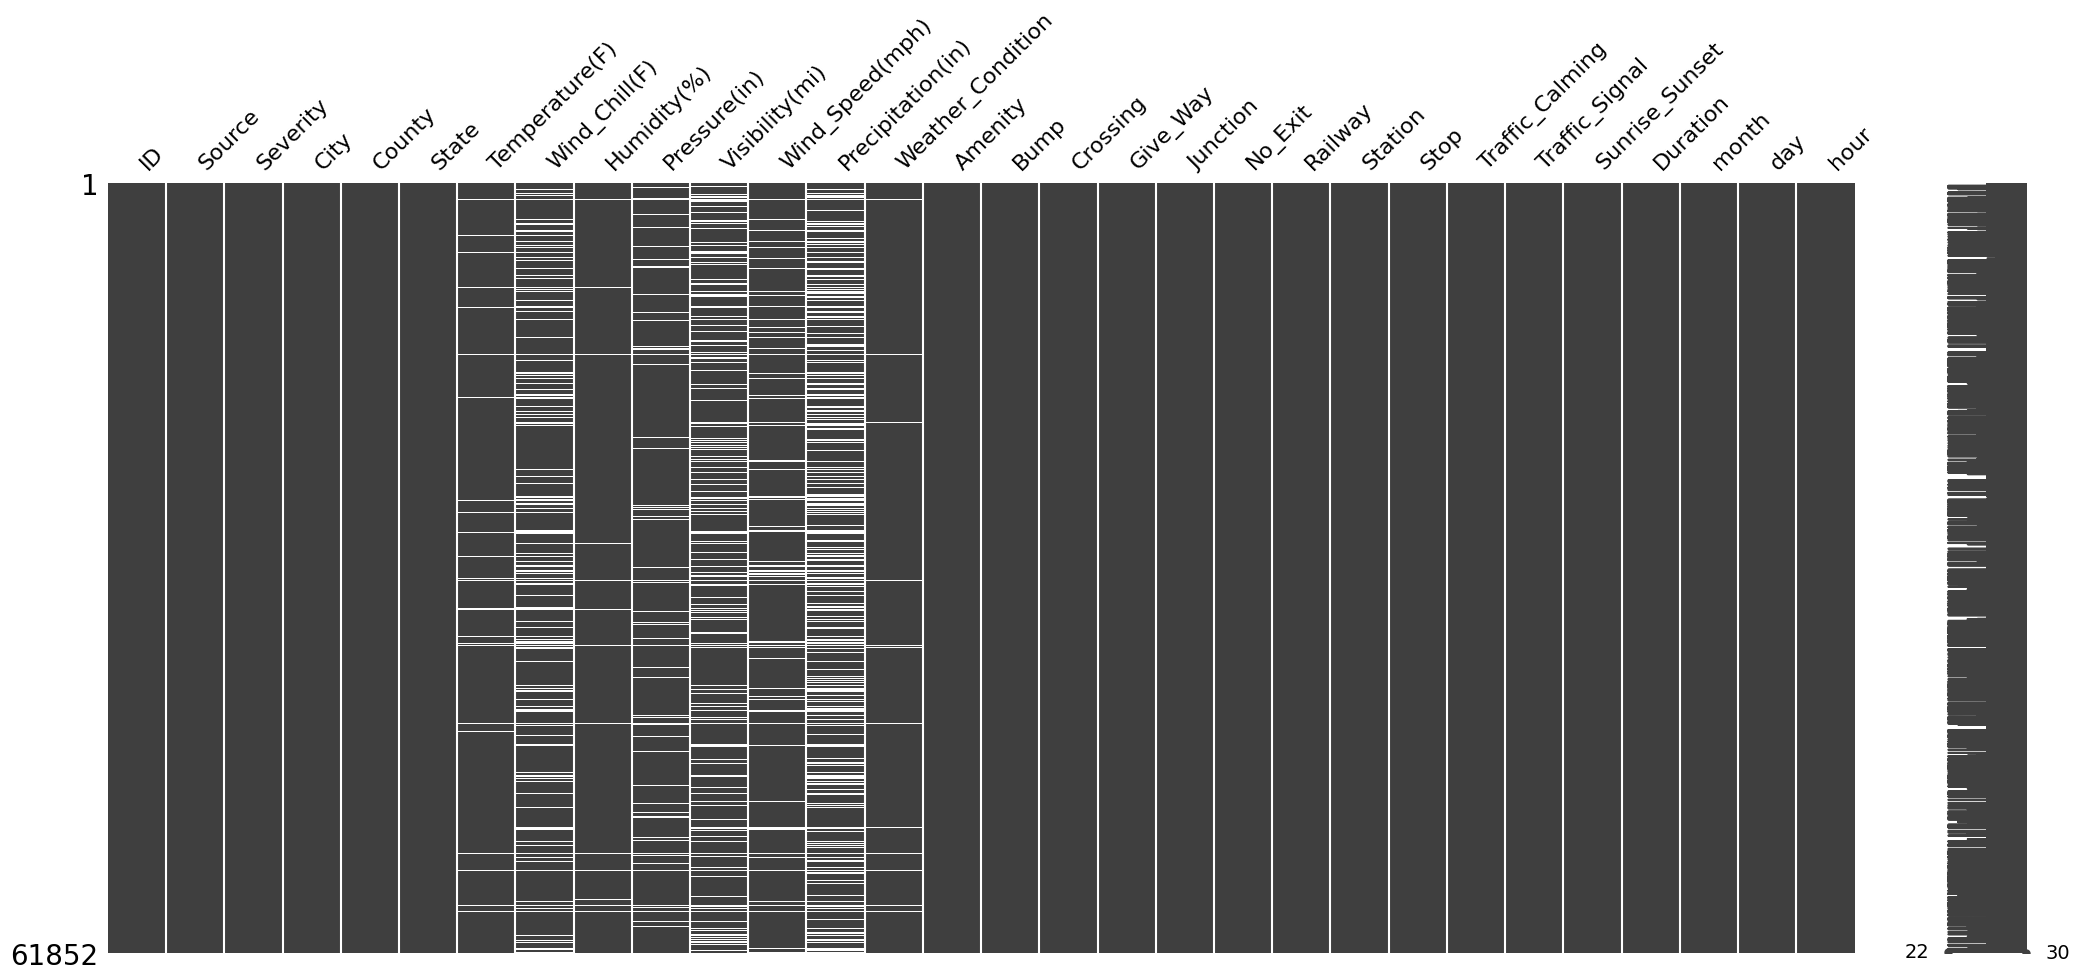

In [8]:
msno.matrix(df10)

In [9]:
df_nulls = df10.copy()
for col in df_nulls:
    if df_nulls[col].isna().sum() == 0:
        del df_nulls[col]
df_nulls

City  Temperature(F)  Wind_Chill(F)  Humidity(%)  Pressure(in)  \
0           Zachary            77.0           77.0         62.0         29.92   
14            Tempe            64.0           64.0         37.0         28.66   
30           Denver            18.0           11.0         40.0           NaN   
40          Augusta            78.0           78.0         84.0         29.50   
51      Minneapolis            18.0            9.0         71.0         28.87   
...             ...             ...            ...          ...           ...   
499948       Madera            52.0           52.0         35.0         30.00   
499971    Charlotte            41.0           36.0         55.0         29.42   
499975  Los Angeles            53.0           53.0         57.0         29.62   
499980    Grayslake            36.0           30.3         73.0         30.51   
499994       Rialto            90.0           90.0          7.0         28.72   

        Visibility(mi)  Wind_Speed(mph)  Precipitation(in) Weather_Condition  \
0                 10.0              5.0                0.0              Fair   
14                10.0              7.0                0.0              Fair   
30                10.0              5.0                0.0     Partly Cloudy   
40                10.0              6.0                0.0              Fair   
51                10.0              7.0                0.0              Fair   
...                ...              ...                ...               ...   
499948             NaN              5.0                0.0              Fair   
499971            10.0              7.0                0.0            Cloudy   
499975            10.0              6.0                0.0            Cloudy   
499980            10.0              6.9                NaN             Clear   
499994            10.0              8.0                0.0              Fair   

       Sunrise_Sunset  
0                 Day  
14                Day  
30              Night  
40              Night  
51              Night  
...               ...  
499948            Day  
499971            Day  
499975            Day  
499980            Day  
499994            Day  

[61852 rows x 10 columns]

In [10]:
df_nulls.describe()

Temperature(F)  Wind_Chill(F)   Humidity(%)  Pressure(in)  \
count    60028.000000   51548.000000  60742.000000  57516.000000   
mean        61.417855      61.207432     64.976392     29.665237   
std         18.488262      21.026011     22.709867      0.480774   
min         12.200000       3.500000      2.000000     28.080000   
25%         48.900000      47.000000     48.000000     29.330000   
50%         63.000000      65.000000     68.000000     29.800000   
75%         75.000000      77.000000     84.000000     30.010000   
max        109.000000     115.000000    100.000000     31.120000   

       Visibility(mi)  Wind_Speed(mph)  Precipitation(in)  
count         48199.0     56635.000000            43214.0  
mean             10.0         7.011412                0.0  
std               0.0         4.629759                0.0  
min              10.0         0.000000                0.0  
25%              10.0         3.500000                0.0  
50%              10.0         7.000000                0.0  
75%              10.0        10.000000                0.0  
max              10.0        19.600000                0.0

In [11]:
# Calculate the percentage of missing values in each column
missing_percentage = df_nulls.isnull().mean() * 100

# Display the missing percentages
missing_percentage = missing_percentage.reset_index()
missing_percentage.columns = ['Column', 'Missing Percentage']
missing_percentage

Column  Missing Percentage
0               City            0.001617
1     Temperature(F)            2.948975
2      Wind_Chill(F)           16.659122
3        Humidity(%)            1.794606
4       Pressure(in)            7.010283
5     Visibility(mi)           22.073660
6    Wind_Speed(mph)            8.434650
7  Precipitation(in)           30.133221
8  Weather_Condition            1.826942
9     Sunrise_Sunset            0.001617

No feature missing greater than 80% nor null similarity to another column - therefore nothing to remove

# Imputation

In [90]:
df11 = df10.copy()

In [91]:
df11

ID   Source  Severity         City            County State  \
0       A2047758  Source2         2      Zachary  East Baton Rouge    LA   
14      A2127689  Source2         2        Tempe          Maricopa    AZ   
30      A1722555  Source2         2       Denver            Denver    CO   
40      A2017804  Source2         2      Augusta          Richmond    GA   
51      A7296001  Source1         2  Minneapolis          Hennepin    MN   
...          ...      ...       ...          ...               ...   ...   
499948  A7364049  Source1         2       Madera            Madera    CA   
499971  A2142579  Source2         2    Charlotte       Mecklenburg    NC   
499975  A1679870  Source2         3  Los Angeles       Los Angeles    CA   
499980  A2239905  Source2         2    Grayslake              Lake    IL   
499994  A7376496  Source1         2       Rialto    San Bernardino    CA   

        Temperature(F)  Wind_Chill(F)  Humidity(%)  Pressure(in)  ...  \
0                 77.0           77.0         62.0         29.92  ...   
14                64.0           64.0         37.0         28.66  ...   
30                18.0           11.0         40.0           NaN  ...   
40                78.0           78.0         84.0         29.50  ...   
51                18.0            9.0         71.0         28.87  ...   
...                ...            ...          ...           ...  ...   
499948            52.0           52.0         35.0         30.00  ...   
499971            41.0           36.0         55.0         29.42  ...   
499975            53.0           53.0         57.0         29.62  ...   
499980            36.0           30.3         73.0         30.51  ...   
499994            90.0           90.0          7.0         28.72  ...   

        Railway  Station  Stop Traffic_Calming  Traffic_Signal  \
0             0        0     0               0               1   
14            0        0     0               0               1   
30            0        0     0               0               0   
40            0        0     0               0               1   
51            0        0     0               0               1   
...         ...      ...   ...             ...             ...   
499948        0        0     0               0               0   
499971        0        0     0               0               0   
499975        0        0     0               0               0   
499980        0        0     0               0               0   
499994        0        0     0               0               0   

        Sunrise_Sunset  Duration  month  day  hour  
0                  Day  0.750556      6   12    10  
14                 Day  1.126389      5   28     7  
30               Night  0.520833     12   17     7  
40               Night  0.995833      8   12     5  
51               Night  0.884167     12   31    18  
...                ...       ...    ...  ...   ...  
499948             Day  0.911944     10   31    10  
499971             Day  1.771111      4    2     8  
499975             Day  4.796389     12   26    10  
499980             Day  0.494722      3   26     8  
499994             Day  1.545556     11    9    16  

[61852 rows x 30 columns]

# mice

In [92]:
X = df11.copy()
X = X.iloc[:,6:13]
X.head()

Temperature(F)  Wind_Chill(F)  Humidity(%)  Pressure(in)  Visibility(mi)  \
0             77.0           77.0         62.0         29.92            10.0   
14            64.0           64.0         37.0         28.66            10.0   
30            18.0           11.0         40.0           NaN            10.0   
40            78.0           78.0         84.0         29.50            10.0   
51            18.0            9.0         71.0         28.87            10.0   

    Wind_Speed(mph)  Precipitation(in)  
0               5.0                0.0  
14              7.0                0.0  
30              5.0                0.0  
40              6.0                0.0  
51              7.0                0.0

In [93]:
### MICE
## Multiple Imputation by Chained Equations
#X_imputed = IterativeImputer(max_iter=15) 
X_imputed = fancyimpute.IterativeImputer().fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)
X_imputed.head()

Temperature(F)  Wind_Chill(F)  Humidity(%)  Pressure(in)  Visibility(mi)  \
0             77.0           77.0         62.0     29.920000            10.0   
14            64.0           64.0         37.0     28.660000            10.0   
30            18.0           11.0         40.0     29.987844            10.0   
40            78.0           78.0         84.0     29.500000            10.0   
51            18.0            9.0         71.0     28.870000            10.0   

    Wind_Speed(mph)  Precipitation(in)  
0               5.0                0.0  
14              7.0                0.0  
30              5.0                0.0  
40              6.0                0.0  
51              7.0                0.0

# Manual impute

In [94]:
# Fill with Character

df11['City'] = df11['City'].fillna('Other')
df11['Weather_Condition'] = df11['Weather_Condition'].fillna('Other')

In [95]:
# Fill Sunrise_Sunset (day/night) via KNN

# Map string values to booleans
mapping = {'Day': True, 'Night': False}
df11['Sunrise_Sunset'] = df11['Sunrise_Sunset'].map(mapping)

# Impute missing values using KNN
imputer = KNNImputer(n_neighbors=1) 
imputed_values = imputer.fit_transform(df11[['Sunrise_Sunset']]).ravel()
df11['Sunrise_Sunset'] = imputed_values.round().astype(bool)

# Map imputed boolean values back to strings
inverse_mapping = {True: 'Day', False: 'Night'}
df11['Sunrise_Sunset'] = df11['Sunrise_Sunset'].map(inverse_mapping)

In [96]:
df11['Sunrise_Sunset'].astype('string')
df11['Sunrise_Sunset'].info()

<class 'pandas.core.series.Series'>
Index: 61852 entries, 0 to 499994
Series name: Sunrise_Sunset
Non-Null Count  Dtype 
--------------  ----- 
61852 non-null  object
dtypes: object(1)
memory usage: 3.0+ MB


In [97]:
df11.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61852 entries, 0 to 499994
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 61852 non-null  string 
 1   Source             61852 non-null  string 
 2   Severity           61852 non-null  int64  
 3   City               61852 non-null  string 
 4   County             61852 non-null  string 
 5   State              61852 non-null  string 
 6   Temperature(F)     60028 non-null  float64
 7   Wind_Chill(F)      51548 non-null  float64
 8   Humidity(%)        60742 non-null  float64
 9   Pressure(in)       57516 non-null  float64
 10  Visibility(mi)     48199 non-null  float64
 11  Wind_Speed(mph)    56635 non-null  float64
 12  Precipitation(in)  43214 non-null  float64
 13  Weather_Condition  61852 non-null  string 
 14  Amenity            61852 non-null  int64  
 15  Bump               61852 non-null  int64  
 16  Crossing           61852 n

In [98]:
df12 = df11.drop(df11.columns[6:13], axis=1)

In [99]:
df13 = pd.concat([df12, X_imputed], axis=1)
df13

ID   Source  Severity         City            County State  \
0       A2047758  Source2         2      Zachary  East Baton Rouge    LA   
14      A2127689  Source2         2        Tempe          Maricopa    AZ   
30      A1722555  Source2         2       Denver            Denver    CO   
40      A2017804  Source2         2      Augusta          Richmond    GA   
51      A7296001  Source1         2  Minneapolis          Hennepin    MN   
...          ...      ...       ...          ...               ...   ...   
499948  A7364049  Source1         2       Madera            Madera    CA   
499971  A2142579  Source2         2    Charlotte       Mecklenburg    NC   
499975  A1679870  Source2         3  Los Angeles       Los Angeles    CA   
499980  A2239905  Source2         2    Grayslake              Lake    IL   
499994  A7376496  Source1         2       Rialto    San Bernardino    CA   

       Weather_Condition  Amenity  Bump  Crossing  ...  month  day  hour  \
0                   Fair        0     0         0  ...      6   12    10   
14                  Fair        0     0         1  ...      5   28     7   
30         Partly Cloudy        0     0         0  ...     12   17     7   
40                  Fair        0     0         0  ...      8   12     5   
51                  Fair        0     0         1  ...     12   31    18   
...                  ...      ...   ...       ...  ...    ...  ...   ...   
499948              Fair        0     0         0  ...     10   31    10   
499971            Cloudy        0     0         0  ...      4    2     8   
499975            Cloudy        0     0         0  ...     12   26    10   
499980             Clear        0     0         0  ...      3   26     8   
499994              Fair        0     0         0  ...     11    9    16   

        Temperature(F)  Wind_Chill(F)  Humidity(%)  Pressure(in)  \
0                 77.0           77.0         62.0     29.920000   
14                64.0           64.0         37.0     28.660000   
30                18.0           11.0         40.0     29.987844   
40                78.0           78.0         84.0     29.500000   
51                18.0            9.0         71.0     28.870000   
...                ...            ...          ...           ...   
499948            52.0           52.0         35.0     30.000000   
499971            41.0           36.0         55.0     29.420000   
499975            53.0           53.0         57.0     29.620000   
499980            36.0           30.3         73.0     30.510000   
499994            90.0           90.0          7.0     28.720000   

        Visibility(mi) Wind_Speed(mph)  Precipitation(in)  
0                 10.0             5.0                0.0  
14                10.0             7.0                0.0  
30                10.0             5.0                0.0  
40                10.0             6.0                0.0  
51                10.0             7.0                0.0  
...                ...             ...                ...  
499948            10.0             5.0                0.0  
499971            10.0             7.0                0.0  
499975            10.0             6.0                0.0  
499980            10.0             6.9                0.0  
499994            10.0             8.0                0.0  

[61852 rows x 30 columns]

<Axes: >

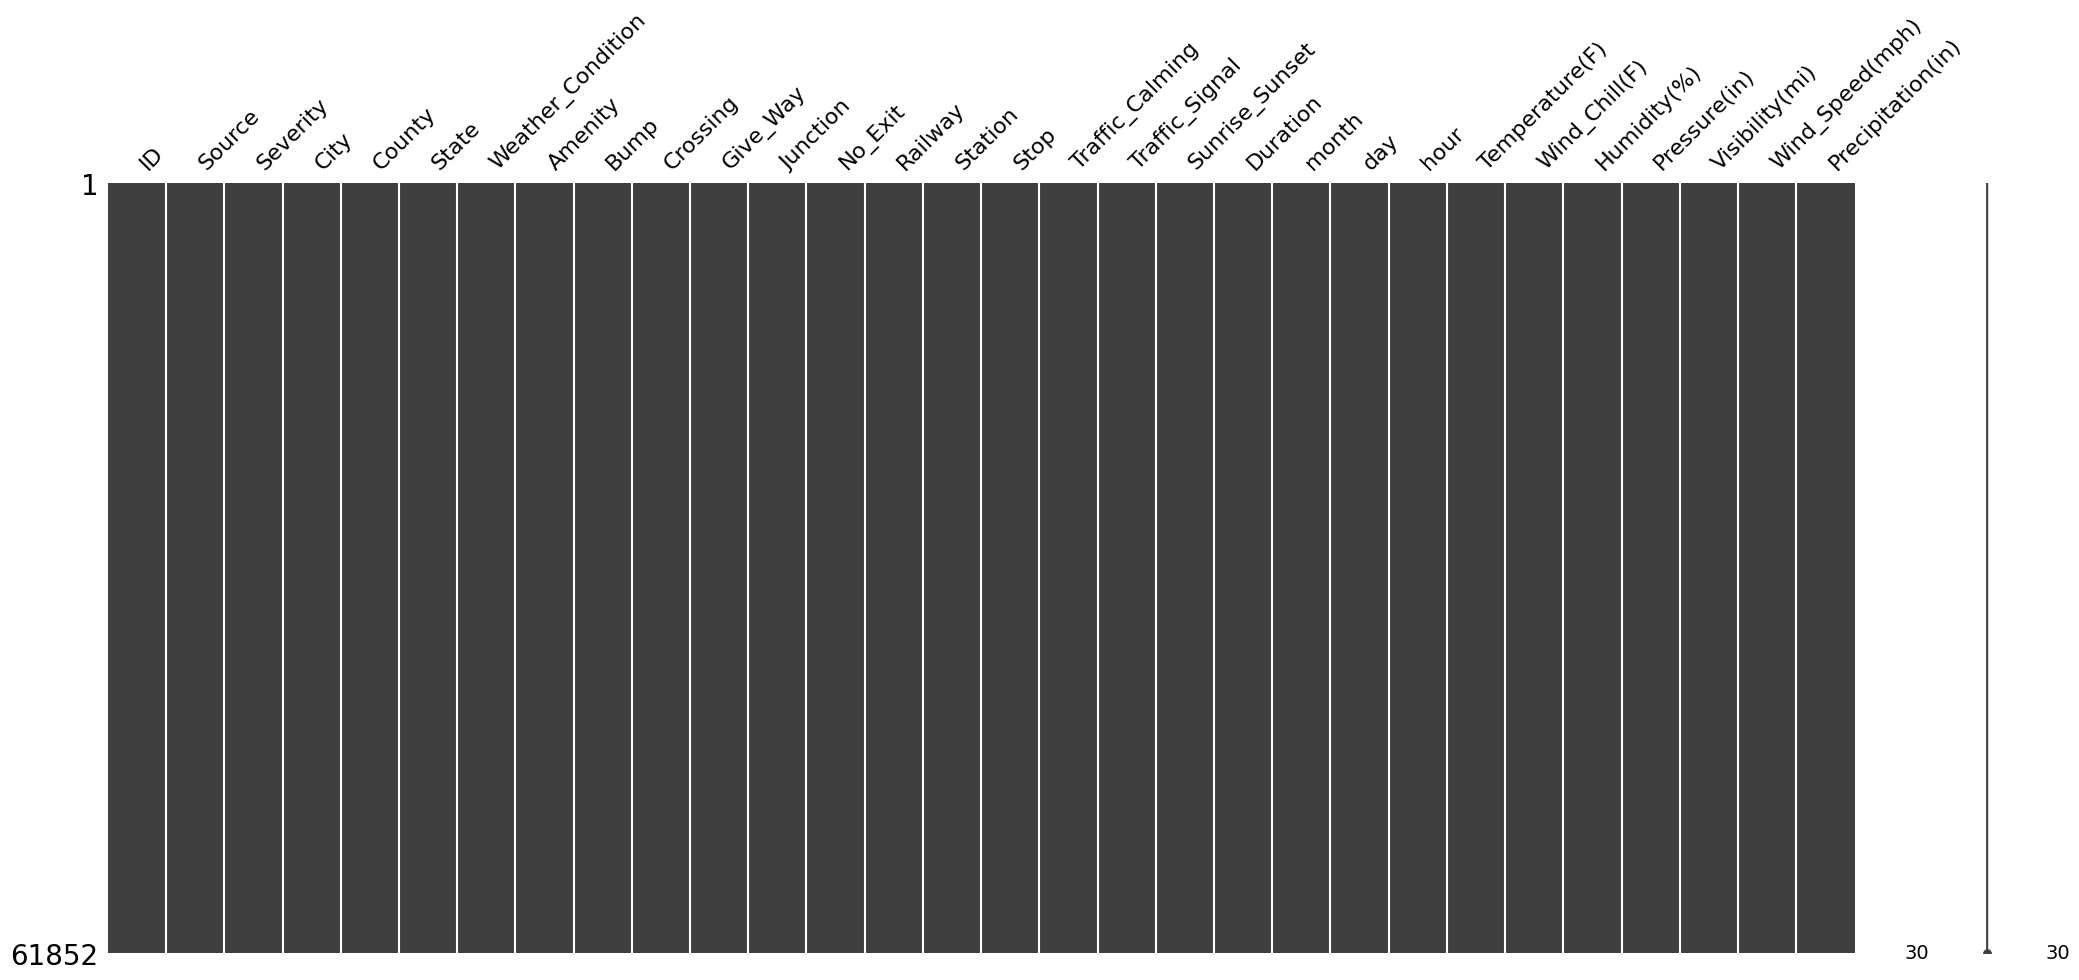

In [101]:
msno.matrix(df13)

In [102]:
# with open('df13.pkl', 'wb') as f:
#     pickle.dump(df13, f)

In [103]:
#Read a pickle file and load the data

with open('df13.pkl', 'rb') as file:
    df13 = pickle.load(file)

In [104]:
df13.shape

(61852, 30)

In [105]:
df13.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61852 entries, 0 to 499994
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 61852 non-null  string 
 1   Source             61852 non-null  string 
 2   Severity           61852 non-null  int64  
 3   City               61852 non-null  string 
 4   County             61852 non-null  string 
 5   State              61852 non-null  string 
 6   Weather_Condition  61852 non-null  string 
 7   Amenity            61852 non-null  int64  
 8   Bump               61852 non-null  int64  
 9   Crossing           61852 non-null  int64  
 10  Give_Way           61852 non-null  int64  
 11  Junction           61852 non-null  int64  
 12  No_Exit            61852 non-null  int64  
 13  Railway            61852 non-null  int64  
 14  Station            61852 non-null  int64  
 15  Stop               61852 non-null  int64  
 16  Traffic_Calming    61852 n

In [106]:
df13

ID   Source  Severity         City            County State  \
0       A2047758  Source2         2      Zachary  East Baton Rouge    LA   
14      A2127689  Source2         2        Tempe          Maricopa    AZ   
30      A1722555  Source2         2       Denver            Denver    CO   
40      A2017804  Source2         2      Augusta          Richmond    GA   
51      A7296001  Source1         2  Minneapolis          Hennepin    MN   
...          ...      ...       ...          ...               ...   ...   
499948  A7364049  Source1         2       Madera            Madera    CA   
499971  A2142579  Source2         2    Charlotte       Mecklenburg    NC   
499975  A1679870  Source2         3  Los Angeles       Los Angeles    CA   
499980  A2239905  Source2         2    Grayslake              Lake    IL   
499994  A7376496  Source1         2       Rialto    San Bernardino    CA   

       Weather_Condition  Amenity  Bump  Crossing  ...  month  day  hour  \
0                   Fair        0     0         0  ...      6   12    10   
14                  Fair        0     0         1  ...      5   28     7   
30         Partly Cloudy        0     0         0  ...     12   17     7   
40                  Fair        0     0         0  ...      8   12     5   
51                  Fair        0     0         1  ...     12   31    18   
...                  ...      ...   ...       ...  ...    ...  ...   ...   
499948              Fair        0     0         0  ...     10   31    10   
499971            Cloudy        0     0         0  ...      4    2     8   
499975            Cloudy        0     0         0  ...     12   26    10   
499980             Clear        0     0         0  ...      3   26     8   
499994              Fair        0     0         0  ...     11    9    16   

        Temperature(F)  Wind_Chill(F)  Humidity(%)  Pressure(in)  \
0                 77.0           77.0         62.0     29.920000   
14                64.0           64.0         37.0     28.660000   
30                18.0           11.0         40.0     29.987844   
40                78.0           78.0         84.0     29.500000   
51                18.0            9.0         71.0     28.870000   
...                ...            ...          ...           ...   
499948            52.0           52.0         35.0     30.000000   
499971            41.0           36.0         55.0     29.420000   
499975            53.0           53.0         57.0     29.620000   
499980            36.0           30.3         73.0     30.510000   
499994            90.0           90.0          7.0     28.720000   

        Visibility(mi) Wind_Speed(mph)  Precipitation(in)  
0                 10.0             5.0                0.0  
14                10.0             7.0                0.0  
30                10.0             5.0                0.0  
40                10.0             6.0                0.0  
51                10.0             7.0                0.0  
...                ...             ...                ...  
499948            10.0             5.0                0.0  
499971            10.0             7.0                0.0  
499975            10.0             6.0                0.0  
499980            10.0             6.9                0.0  
499994            10.0             8.0                0.0  

[61852 rows x 30 columns]

In [107]:
df14 = df13.copy()

In [63]:
# categories encoding

# from sklearn.preprocessing import LabelEncoder

# def encode_columns(df, column_list):
#   le = LabelEncoder()
#   for column in column_list:
#     non_null_values = df[column][df[column].notnull()]
#     le.fit(non_null_values)
#     df[column + '_encoded'] = df[column].apply(lambda x: le.transform([x])[0] if pd.notnull(x) else x)
#   return df

# columns_to_encode = ['Source', 'City', 'County', 'State', 'Weather_Condition', 'Sunrise_Sunset']
# df5 = encode_columns(df5, columns_to_encode)